In [1]:
import os
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.layers import *
from keras.optimizers import *
from keras.models import Model
from keras.callbacks import *
from keras import backend as K
from keras import optimizers
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import matthews_corrcoef
from joblib import Parallel, delayed

/home/hakubishin3/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### settings

In [2]:
save_dir = "./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/"

In [4]:
N_SPLITS = 5
MAX_THREADS = 8
N_TRAIN = 10
max_num = 127
min_num = -128
n_samples = 800000
sample_duration = 0.02
sample_rate = n_samples * (1 / sample_duration)

### process

In [5]:
from scipy.signal import butter, sosfilt
import pywt

def maddest(d, axis=None):
    """
    Mean Absolute Deviation
    """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def high_pass_filter(x, low_cutoff=1000, sample_rate=sample_rate):
    """
    From @randxie https://github.com/randxie/Kaggle-VSB-Baseline/blob/master/src/utils/util_signal.py
    Modified to work with scipy version 1.1.0 which does not have the fs parameter
    """
    # nyquist frequency is half the sample rate https://en.wikipedia.org/wiki/Nyquist_frequency
    nyquist = 0.5 * sample_rate
    norm_low_cutoff = low_cutoff / nyquist
    # scipy version 1.1.0
    sos = butter(10, Wn=[norm_low_cutoff], btype='highpass', output='sos')
    filtered_sig = sosfilt(sos, x)
    return filtered_sig

def denoise_signal(x, wavelet='db4', level=1):
    """
    1. Adapted from waveletSmooth function found here:
    http://connor-johnson.com/2016/01/24/using-pywavelets-to-remove-high-frequency-noise/
    2. Threshold equation and using hard mode in threshold as mentioned
    in section '3.2 denoising based on optimized singular values' from paper by Tomas Vantuch:
    http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    """
    # Decompose to get the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode="per" )
    # Calculate sigma for threshold as defined in http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    # As noted by @harshit92 MAD referred to in the paper is Mean Absolute Deviation not Median Absolute Deviation
    sigma = (1/0.6745) * maddest( coeff[-level] )
    # Calculte the univeral threshold
    uthresh = sigma * np.sqrt( 2*np.log(len(x)))
    coeff[1:] = (pywt.threshold( i, value=uthresh, mode='hard') for i in coeff[1:])
    # Reconstruct the signal using the thresholded coefficients
    return pywt.waverec( coeff, wavelet, mode='per')

In [6]:
df_train = pd.read_csv('../data/input/metadata_train.csv')
df_train = df_train.set_index(['id_measurement', 'phase'])

In [7]:
def get_features(dataset='train', split_parts=10):
    if dataset == 'train':
        cache_file = 'X.npy'
        meta_file = '../data/input/metadata_train.csv'
    elif dataset == 'test':
        cache_file = 'X_test.npy'
        meta_file = '../data/input/metadata_test.csv'

    meta_df = pd.read_csv(meta_file)

    data_measurements = meta_df.pivot(
        index='id_measurement', columns='phase', values='signal_id'
    )
    data_measurements = data_measurements.values
    data_measurements = np.array_split(data_measurements, split_parts, axis=0)
    X = Parallel(n_jobs=min(split_parts, MAX_THREADS), verbose=1)(delayed(prep_data)(p, dataset) for p in data_measurements)
    X = np.concatenate(X, axis=0)

    if dataset == 'train':
        # y = meta_df.loc[meta_df['phase']==0, 'target'].values
        # y = meta_df.groupby("id_measurement")["target"].max().sort_index().values
        y = meta_df.groupby("id_measurement")["target"].sum().values
        y[y < 2] = 0
        y[y >= 2] = 1

        np.save(save_dir + "X.npy", X)
        np.save(save_dir + "y.npy", y)
    elif dataset == 'test':
        y = None
        np.save(save_dir + "X_test.npy", X)

    return X, y

In [8]:
def min_max_transf(ts, min_data, max_data, range_needed=(-1,1)):
    if min_data < 0:
        ts_std = (ts + abs(min_data)) / (max_data + abs(min_data))
    else:
        ts_std = (ts - min_data) / (max_data - min_data)
    if range_needed[0] < 0:    
        return ts_std * (range_needed[1] + abs(range_needed[0])) + range_needed[0]
    else:
        return ts_std * (range_needed[1] - range_needed[0]) + range_needed[0]

In [9]:
def prep_data(signal_ids, dataset="train"):
    signal_ids_all = np.concatenate(signal_ids)
    if dataset == "train":
        praq_data = pq.read_pandas('../data/input/train.parquet', columns=[str(i) for i in signal_ids_all]).to_pandas()
    elif dataset == "test":
        praq_data = pq.read_pandas('../data/input/test.parquet', columns=[str(i) for i in signal_ids_all]).to_pandas()
    else:
        raise ValueError("Unknown dataset")
    X = []
    for sids in signal_ids:
        data = praq_data[[str(s) for s in sids]].values.T
        X_signal = [transform_ts(signal) for signal in data]
        X_signal = np.concatenate(X_signal, axis=1)
        X.append(X_signal)
    X = np.asarray(X)
    return X

In [10]:
from scipy.signal import butter, sosfilt, find_peaks, peak_prominences
import pywt
import tsfresh
distance = 50
prominence = 10 / max_num
    
def transform_ts(ts, n_dim=160, min_max=(-1,1)):
    ts_hp = high_pass_filter(ts, low_cutoff=10000)
    ts_denoised = denoise_signal(ts_hp, wavelet='db4', level=1)
    ts_std = min_max_transf(ts_denoised, min_data=min_num, max_data=max_num)

    ts_denoised_nohp = denoise_signal(ts, wavelet='db4', level=1)
    ts_std_nohp = min_max_transf(ts_denoised_nohp, min_data=min_num, max_data=max_num)
    
    sample_size = 800000
    bucket_size = int(sample_size / n_dim)
    new_ts = []
    
    for i in range(0, sample_size, bucket_size):
        ts_range = ts_std[i:i + bucket_size]
        pos_peaks, _ = find_peaks(ts_range, distance=distance, prominence=prominence)
        neg_peaks, _ = find_peaks(ts_range*-1, distance=distance, prominence=prominence)
        widths = np.diff(pos_peaks)
        prominences = peak_prominences(ts_range, pos_peaks)[0]

        peak_result = {
            'pos_peak_count': pos_peaks.size,
            'neg_peak_count': neg_peaks.size,
            'peak_count_buchet': pos_peaks.size + neg_peaks.size,
            'width_mean_buchet': (widths.mean() / bucket_size if widths.size else 1.) - 1,
            'width_max_buchet': (widths.max() / bucket_size if widths.size else 1.) - 1,
            'width_min_buchet': (widths.min() / bucket_size if widths.size else 1.) - 1,
            'prominence_mean_buchet': prominences.mean() / 2 if prominences.size else 0.,
            'prominence_max_buchet': prominences.max() / 2 if prominences.size else 0.,
            'prominence_min_buchet': prominences.min() / 2 if prominences.size else 0.,
        }
        peak_result = np.array(list(peak_result.values())).astype(float)
        
        """
        ts_range_nohp = ts_std_nohp[i:i + bucket_size]
        # non-linearity
        fe_c3 = tsfresh.feature_extraction.feature_calculators.c3(ts_range_nohp, lag=100)
        # complexity
        fe_cid_ce = tsfresh.feature_extraction.feature_calculators.cid_ce(ts_range_nohp, normalize=False)

        new_ts.append(np.concatenate([
            peak_result,
            np.asarray([fe_c3, fe_cid_ce])
            ]))
        """
        new_ts.append(peak_result)

    return np.asarray(new_ts)

In [11]:
X, y = get_features("train", split_parts=32)
print(X.shape, y.shape)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  32 out of  32 | elapsed:  4.7min finished


(2904, 160, 27) (2904,)


In [29]:
X = np.load(save_dir + "X.npy")
y = np.load(save_dir + "y.npy")
print(X.shape, y.shape)

(2904, 160, 27) (2904,)


In [13]:
%%time
meta_test = pd.read_csv('../data/input/metadata_test.csv')
meta_test = meta_test.set_index(['signal_id'])
X_test_input, _ = get_features("test", split_parts=16)
X_test_input.shape

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed: 10.2min finished


CPU times: user 942 ms, sys: 765 ms, total: 1.71 s
Wall time: 10min 16s


In [30]:
X_test_input = np.load(save_dir + "X_test.npy")
print(X_test_input.shape)

(6779, 160, 27)


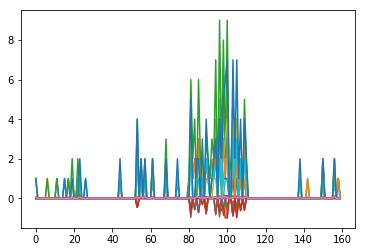

In [31]:
plt.plot(X[1//3, :, :])
plt.show()

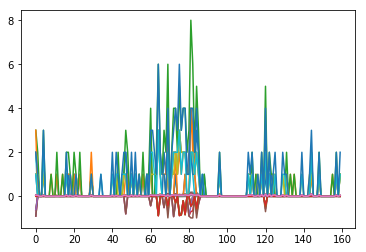

In [32]:
plt.plot(X_test_input[0, :, :])
plt.show()

### 最初の系列を除外

In [33]:
n_remove = 10
X = X[:, n_remove:, :]
X_test_input = X_test_input[:, n_remove:, :]
X.shape, X_test_input.shape

((2904, 150, 27), (6779, 150, 27))

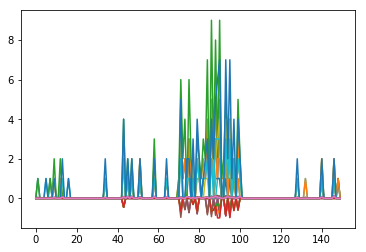

In [34]:
plt.plot(X[1//3, :, :])
plt.show()

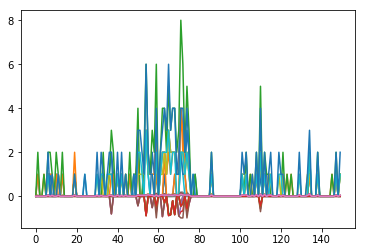

In [35]:
plt.plot(X_test_input[0, :, :])
plt.show()

### scaling

In [37]:
# number of peakをスケーリング
target_cols = [0, 1, 2]
n_features = X.shape[2]//3
target_all = []
target_all.extend([col for col in target_cols])
target_all.extend([col+n_features for col in target_cols])
target_all.extend([col+2*n_features for col in target_cols])

for col in target_all:
    print(X[:, :, col].max())
    print(X_test_input[:, :, col].max())

71.0
81.0
75.0
79.0
144.0
158.0
70.0
72.0
70.0
73.0
140.0
143.0
71.0
81.0
70.0
81.0
141.0
160.0


In [38]:
for col in target_all:
    X[:, :, col] = X[:, :, col] / 160
    X_test_input[:, :, col] = X_test_input[:, :, col] / 160
    print(X[:, :, col].max())
    print(X_test_input[:, :, col].max())

0.44375
0.50625
0.46875
0.49375
0.9
0.9875
0.4375
0.45
0.4375
0.45625
0.875
0.89375
0.44375
0.50625
0.4375
0.50625
0.88125
1.0


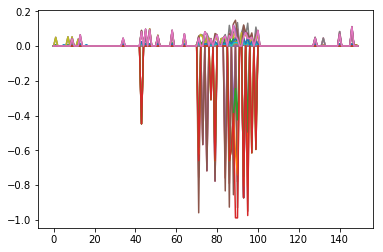

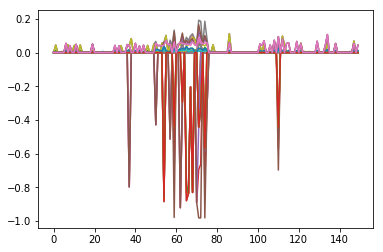

In [39]:
plt.plot(X[1//3, :, :])
plt.show()
plt.plot(X_test_input[0, :, :])
plt.show()

### add features

In [40]:
X_add = np.load("./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.39/X.npy")
X_add_test_input = np.load("./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.39/X_test.npy")
X_add.shape, X_add_test_input.shape

((2904, 160, 33), (6779, 160, 33))

In [41]:
n_remove = 10
X_add = X_add[:, n_remove:, :]
X_add_test_input = X_add_test_input[:, n_remove:, :]
X_add.shape, X_add_test_input.shape

((2904, 150, 33), (6779, 150, 33))

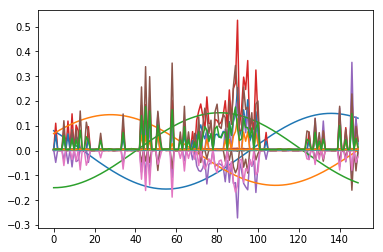

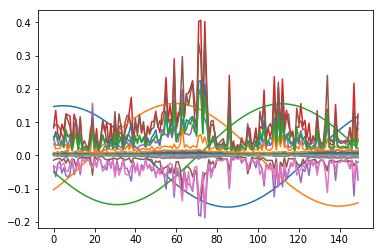

In [42]:
plt.plot(X_add[1//3, :, :])
plt.show()
plt.plot(X_add_test_input[0, :, :])
plt.show()

In [43]:
X = np.concatenate((X, X_add), axis=2)
X_test_input = np.concatenate((X_test_input, X_add_test_input), axis=2)
X.shape, X_test_input.shape

((2904, 150, 60), (6779, 150, 60))

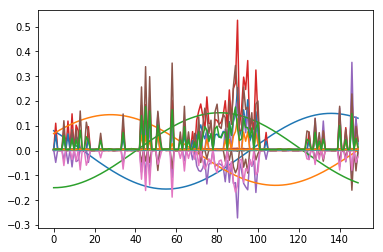

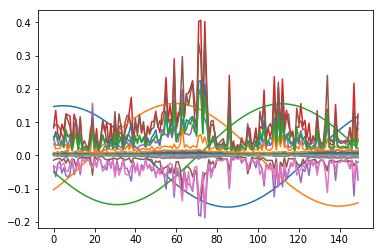

In [44]:
plt.plot(X_add[1//3, :, :])
plt.show()
plt.plot(X_add_test_input[0, :, :])
plt.show()

### set model

In [45]:
# https://www.kaggle.com/suicaokhoailang/lstm-attention-baseline-0-652-lb

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [46]:
def model_lstm(input_shape):
    inp = Input(shape=(input_shape[1], input_shape[2],))
    x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(inp)
    x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
    x = Attention(input_shape[1])(x)
    x = Dense(64, activation="relu")(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    
    return model

In [47]:
def matthews_correlation(y_true, y_pred):
    '''Calculates the Matthews correlation coefficient measure for quality
    of binary classification problems.
    '''
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

### train adversal validation

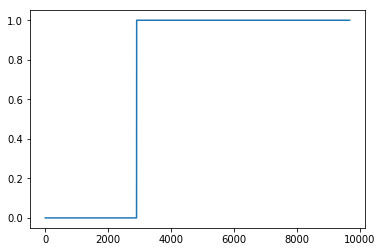

((9683, 150, 60), (9683,), 6779.0)

In [72]:
X_total = np.concatenate((X, X_test_input))
y_total = np.ones(len(X_total))
y_total[:len(X)] = 0

plt.plot(y_total)
plt.show()
X_total.shape, y_total.shape, y_total.sum()

In [73]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)), str(round(roc_val,4))), end=100*' '+'\n')
        logs['val_auc'] = roc_val
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

In [74]:
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X_total, y_total))
preds_val = []
y_val = []

for idx, (train_idx, val_idx) in enumerate(splits):
    K.clear_session()
    print("Beginning fold {}".format(idx+1))
    train_X, train_y, val_X, val_y = X_total[train_idx], y_total[train_idx], X_total[val_idx], y_total[val_idx]
    model = model_lstm(train_X.shape)
    optimizer = Adam(lr=1e-3)
    model.compile(optimizer=optimizer, loss='binary_crossentropy')
    ckpt = ModelCheckpoint(
        save_dir + 'weights_{}.h5'.format(idx), save_best_only=True,
        save_weights_only=True, verbose=1, monitor='val_auc', mode='max'
    )
    roc_auc = roc_callback(training_data=(train_X, train_y), validation_data=(val_X, val_y))
    early_stopping = EarlyStopping(monitor='val_auc', patience=5, mode="max")

    model.fit(
        train_X, train_y, batch_size=128, epochs=100,
        validation_data=[val_X, val_y], callbacks=[roc_auc, ckpt, early_stopping]
    )
    
    model.load_weights(save_dir + 'weights_{}.h5'.format(idx))
    preds_val.append(model.predict(val_X, batch_size=512))
    y_val.append(val_y)

preds_val = np.concatenate(preds_val)[...,0]
y_val = np.concatenate(y_val)
preds_val.shape, y_val.shape

Beginning fold 1
Train on 7746 samples, validate on 1937 samples
Epoch 1/100
7746/7746 [==============================] - 4s 539us/step - loss: 0.6209 - val_loss: 0.6021
roc-auc: 0.5822 - roc-auc_val: 0.6003                                                                                                    

Epoch 00001: val_auc improved from -inf to 0.60028, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_0.h5
Epoch 2/100
7746/7746 [==============================] - 3s 390us/step - loss: 0.6037 - val_loss: 0.5937
roc-auc: 0.6013 - roc-auc_val: 0.6193                                                                                                    

Epoch 00002: val_auc improved from 0.60028 to 0.61934, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_0.h5
Epoch 3/100
7746/7746 [==============================] - 3s 402us/step - loss: 0.5959 - val_loss: 0.5932
roc-auc: 0.6101 - roc-auc_val: 0.6262                                

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, preds_val)

In [ ]:
target = np.ones(len(X_total))
target = target * -1
target[:len(y)] = y
target.shape, target[target != -1].sum(), y.sum()

In [ ]:
val_idx_list = []
for idx, (train_idx, val_idx) in enumerate(splits):
    val_idx_list.append(val_idx)
val_idx_list = np.concatenate(val_idx_list)

In [ ]:
result = []
for idx, preds, test_flg in zip(val_idx_list, preds_val, y_val):
    result.append((idx, preds, test_flg))

result = pd.DataFrame(result, columns=["idx", "preds", "test_flg"])
result = result.sort_values("idx").reset_index(drop=True)
result["target"] = target
result.head()

In [ ]:
# check
print(result.query("test_flg == 0").target.sum())
result[["target", "test_flg"]].plot()
plt.show()
result.query("test_flg == 0").preds.hist()
plt.show()
result.query("test_flg == 1").preds.hist()
plt.show()

In [ ]:
result.to_csv(save_dir + "adversarial_validation_result.csv", index=False, header=True)

### get adversal validation result

In [ ]:
ad_result = pd.read_csv(save_dir + "adversarial_validation_result.csv")
ad_train = ad_result.query("test_flg == 0")
print(ad_train.test_flg.sum(), ad_train.target.sum(), y.sum())
ad_train.head()

In [ ]:
plt.hist(ad_train.query("target == 0")["preds"].values, bins=np.arange(0, 1.1, 0.1))
plt.hist(ad_train.query("target == 1")["preds"].values, bins=np.arange(0, 1.1, 0.1))
plt.show()

In [ ]:
# cut adversarial probabilities (for train) in 5 buckets
adver_idx_08_to_1 = ad_train.query("preds >= 0.80").idx.tolist()
adver_idx_06_to_08 = ad_train.query("0.80 > preds >= 0.60").idx.tolist()
adver_idx_04_to_06 = ad_train.query("0.60 > preds >= 0.40").idx.tolist()
adver_idx_02_to_04 = ad_train.query("0.40 > preds >= 0.20").idx.tolist()
adver_idx_00_to_02 = ad_train.query("0.20 > preds >= 0.00").idx.tolist()

print(len(adver_idx_08_to_1), len(adver_idx_06_to_08), len(adver_idx_04_to_06), len(adver_idx_02_to_04), len(adver_idx_00_to_02))
print(len(adver_idx_08_to_1)+len(adver_idx_06_to_08)+len(adver_idx_04_to_06)+len(adver_idx_02_to_04)+len(adver_idx_00_to_02))
print(len(y))

print(y[adver_idx_08_to_1].sum(), y[adver_idx_06_to_08].sum(), y[adver_idx_04_to_06].sum(), y[adver_idx_02_to_04].sum(), y[adver_idx_00_to_02].sum())
print(y[adver_idx_08_to_1].sum()+y[adver_idx_06_to_08].sum()+y[adver_idx_04_to_06].sum()+y[adver_idx_02_to_04].sum()+y[adver_idx_00_to_02].sum())
print(y.sum())

In [ ]:
adver_idx_08_to_1_pos = ad_train.query("preds >= 0.80 & target == 1").idx.tolist()
adver_idx_06_to_08_pos = ad_train.query("0.80 > preds >= 0.60 & target == 1").idx.tolist()
adver_idx_04_to_06_pos = ad_train.query("0.60 > preds >= 0.40 & target == 1").idx.tolist()
adver_idx_02_to_04_pos = ad_train.query("0.40 > preds >= 0.20 & target == 1").idx.tolist()
adver_idx_00_to_02_pos = ad_train.query("0.20 > preds >= 0.00 & target == 1").idx.tolist()

print(len(adver_idx_08_to_1_pos), len(adver_idx_06_to_08_pos), len(adver_idx_04_to_06_pos), len(adver_idx_02_to_04_pos), len(adver_idx_00_to_02_pos))
print(len(adver_idx_08_to_1_pos)+len(adver_idx_06_to_08_pos)+len(adver_idx_04_to_06_pos)+len(adver_idx_02_to_04_pos)+len(adver_idx_00_to_02_pos))
print(len(y))

In [ ]:
fold_index = np.zeros(len(y))
fold_index[adver_idx_08_to_1] = 1
fold_index[adver_idx_08_to_1_pos] = 2
fold_index[adver_idx_06_to_08] = 3
fold_index[adver_idx_06_to_08_pos] = 4
fold_index[adver_idx_04_to_06] = 5
fold_index[adver_idx_04_to_06_pos] = 6
fold_index[adver_idx_02_to_04] = 7
fold_index[adver_idx_02_to_04_pos] = 8
fold_index[adver_idx_00_to_02] = 9
fold_index[adver_idx_00_to_02_pos] = 10

print(len(fold_index[fold_index==1]), len(fold_index[fold_index==2]), len(fold_index[fold_index==1])+len(fold_index[fold_index==2]))
print(len(fold_index[fold_index==3]), len(fold_index[fold_index==4]), len(fold_index[fold_index==3])+len(fold_index[fold_index==4]))
print(len(fold_index[fold_index==5]), len(fold_index[fold_index==6]), len(fold_index[fold_index==5])+len(fold_index[fold_index==6]))
print(len(fold_index[fold_index==7]), len(fold_index[fold_index==8]), len(fold_index[fold_index==7])+len(fold_index[fold_index==8]))
print(len(fold_index[fold_index==9]), len(fold_index[fold_index==10]), len(fold_index[fold_index==9])+len(fold_index[fold_index==10]))

### train

In [48]:
best_thr_list = []
best_score_list = []
preds_val_list = []

def threshold_search(y_true, y_proba):
    thresholds = np.linspace(0.0, 1.0, 101)
    scores = [matthews_corrcoef(y_true, (y_proba > t).astype(np.uint8)) for t in thresholds]
    best_idx = np.argmax(scores)
    return thresholds[best_idx], scores[best_idx]

In [49]:
class CalcBestMcc(Callback):
    """calculate mcc using by validation data"""
    def on_epoch_end(self, epoch, logs):
        x_val, y_val = self.validation_data[0], self.validation_data[1]
        y_pred = np.asarray(self.model.predict(x_val))
        y_val = y_val.reshape(-1)
        y_pred = y_pred.reshape(-1)
        
        score = matthews_corrcoef(y_val, (y_pred > 0.5).astype(int))
        logs['val_matthews_correlation_end'] = score
        print(f"val_matthews_correlation_end: {score}")
        return

In [52]:
def train_per_fold(n_train, idx, train_X, train_y, val_X, val_y):
    model = model_lstm(train_X.shape)
    optimizer = Adam(lr=1e-3)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[matthews_correlation])
    save_model_name = f'weights_{n_train}_{idx}.h5'
    ckpt = ModelCheckpoint(
        save_dir + save_model_name, save_best_only=True,
        save_weights_only=True, verbose=1, monitor='val_matthews_correlation', mode='max'
    )    
    #mcc_ = CalcBestMcc()
    model.fit(
        train_X, train_y, batch_size=128, epochs=50, verbose=1,
        validation_data=[val_X, val_y], callbacks=[ckpt]
    )

    model.load_weights(save_dir + save_model_name)
    preds_train = np.squeeze(model.predict(train_X, batch_size=512))
    preds_val = np.squeeze(model.predict(val_X, batch_size=512))
    preds_test = np.squeeze(model.predict(X_test_input, batch_size=300, verbose=1))

    return preds_train, preds_val, preds_test

In [53]:
fold_index = y

In [54]:
splits = list(StratifiedKFold(
    n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, fold_index))

for n_train in range(N_TRAIN):
    print(f"===== n_train = {n_train} =====")

    for idx, (train_idx, val_idx) in enumerate(splits):
        K.clear_session()
        print("Beginning fold {}".format(idx+1))
        train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]        
        preds_train, preds_val, preds_test = train_per_fold(n_train, idx, train_X, train_y, val_X, val_y)
        np.save(save_dir + f"preds_train_{n_train}_{idx}.npy", preds_train)
        np.save(save_dir + f"preds_val_{n_train}_{idx}.npy", preds_val)
        np.save(save_dir + f"preds_test_{n_train}_{idx}.npy", preds_test)

        print("train result:", threshold_search(train_y, preds_train))
        print("val result:", threshold_search(val_y, preds_val))

===== n_train = 0 =====
Beginning fold 1
Train on 2323 samples, validate on 581 samples
Epoch 1/50
2323/2323 [==============================] - 4s 2ms/step - loss: 0.3611 - matthews_correlation: 0.0092 - val_loss: 0.2164 - val_matthews_correlation: 0.0000e+00

Epoch 00001: val_matthews_correlation improved from -inf to 0.00000, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_0_0.h5
Epoch 2/50
2323/2323 [==============================] - 1s 413us/step - loss: 0.2035 - matthews_correlation: 0.0000e+00 - val_loss: 0.1600 - val_matthews_correlation: 0.1349

Epoch 00002: val_matthews_correlation improved from 0.00000 to 0.13494, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_0_0.h5
Epoch 3/50
2323/2323 [==============================] - 1s 421us/step - loss: 0.1444 - matthews_correlation: 0.3340 - val_loss: 0.1678 - val_matthews_correlation: 0.4548

Epoch 00003: val_matthews_correlation improved from 0.13494 to 0.45475, saving mod


Epoch 00031: val_matthews_correlation did not improve from 0.75745
Epoch 32/50
2323/2323 [==============================] - 1s 398us/step - loss: 0.0830 - matthews_correlation: 0.6549 - val_loss: 0.0842 - val_matthews_correlation: 0.7115

Epoch 00032: val_matthews_correlation did not improve from 0.75745
Epoch 33/50
2323/2323 [==============================] - 1s 397us/step - loss: 0.0774 - matthews_correlation: 0.7215 - val_loss: 0.0829 - val_matthews_correlation: 0.7358

Epoch 00033: val_matthews_correlation did not improve from 0.75745
Epoch 34/50
2323/2323 [==============================] - 1s 400us/step - loss: 0.0732 - matthews_correlation: 0.7251 - val_loss: 0.0941 - val_matthews_correlation: 0.6440

Epoch 00034: val_matthews_correlation did not improve from 0.75745
Epoch 35/50
2323/2323 [==============================] - 1s 398us/step - loss: 0.0703 - matthews_correlation: 0.7337 - val_loss: 0.1059 - val_matthews_correlation: 0.6162

Epoch 00035: val_matthews_correlation did n

/home/hakubishin3/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


train result: (0.19, 0.7784067225863651)
val result: (0.44, 0.753645477752651)
Beginning fold 2
Train on 2323 samples, validate on 581 samples
Epoch 1/50
2323/2323 [==============================] - 2s 1ms/step - loss: 0.3762 - matthews_correlation: 0.0062 - val_loss: 0.2263 - val_matthews_correlation: 0.0000e+00

Epoch 00001: val_matthews_correlation improved from -inf to 0.00000, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_0_1.h5
Epoch 2/50
2323/2323 [==============================] - 1s 401us/step - loss: 0.2195 - matthews_correlation: 0.0000e+00 - val_loss: 0.2097 - val_matthews_correlation: 0.0000e+00

Epoch 00002: val_matthews_correlation did not improve from 0.00000
Epoch 3/50
2323/2323 [==============================] - 1s 393us/step - loss: 0.1704 - matthews_correlation: 0.0936 - val_loss: 0.1770 - val_matthews_correlation: 0.2253

Epoch 00003: val_matthews_correlation improved from 0.00000 to 0.22533, saving model to ./save/kernel_5-fold_LSTM

2323/2323 [==============================] - 1s 412us/step - loss: 0.0798 - matthews_correlation: 0.7338 - val_loss: 0.0956 - val_matthews_correlation: 0.5793

Epoch 00032: val_matthews_correlation did not improve from 0.62712
Epoch 33/50
2323/2323 [==============================] - 1s 416us/step - loss: 0.0820 - matthews_correlation: 0.6491 - val_loss: 0.1221 - val_matthews_correlation: 0.6160

Epoch 00033: val_matthews_correlation did not improve from 0.62712
Epoch 34/50
2323/2323 [==============================] - 1s 416us/step - loss: 0.0805 - matthews_correlation: 0.7172 - val_loss: 0.0984 - val_matthews_correlation: 0.5492

Epoch 00034: val_matthews_correlation did not improve from 0.62712
Epoch 35/50
2323/2323 [==============================] - 1s 420us/step - loss: 0.0777 - matthews_correlation: 0.6957 - val_loss: 0.0983 - val_matthews_correlation: 0.6116

Epoch 00035: val_matthews_correlation did not improve from 0.62712
Epoch 36/50
2323/2323 [==============================] -

2323/2323 [==============================] - 1s 395us/step - loss: 0.1037 - matthews_correlation: 0.6282 - val_loss: 0.0862 - val_matthews_correlation: 0.6864

Epoch 00012: val_matthews_correlation did not improve from 0.71661
Epoch 13/50
2323/2323 [==============================] - 1s 397us/step - loss: 0.0979 - matthews_correlation: 0.6107 - val_loss: 0.0867 - val_matthews_correlation: 0.7312

Epoch 00013: val_matthews_correlation improved from 0.71661 to 0.73118, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_0_2.h5
Epoch 14/50
2323/2323 [==============================] - 1s 416us/step - loss: 0.0954 - matthews_correlation: 0.6808 - val_loss: 0.0850 - val_matthews_correlation: 0.7395

Epoch 00014: val_matthews_correlation improved from 0.73118 to 0.73948, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_0_2.h5
Epoch 15/50
2323/2323 [==============================] - 1s 418us/step - loss: 0.0918 - matthews_correlation: 0.602

2323/2323 [==============================] - 1s 405us/step - loss: 0.0787 - matthews_correlation: 0.7369 - val_loss: 0.0729 - val_matthews_correlation: 0.7686

Epoch 00045: val_matthews_correlation did not improve from 0.78070
Epoch 46/50
2323/2323 [==============================] - 1s 407us/step - loss: 0.0724 - matthews_correlation: 0.6849 - val_loss: 0.0713 - val_matthews_correlation: 0.7860

Epoch 00046: val_matthews_correlation improved from 0.78070 to 0.78604, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_0_2.h5
Epoch 47/50
2323/2323 [==============================] - 1s 414us/step - loss: 0.0713 - matthews_correlation: 0.7412 - val_loss: 0.0752 - val_matthews_correlation: 0.7077

Epoch 00047: val_matthews_correlation did not improve from 0.78604
Epoch 48/50
2323/2323 [==============================] - 1s 409us/step - loss: 0.0698 - matthews_correlation: 0.7480 - val_loss: 0.0914 - val_matthews_correlation: 0.7315

Epoch 00048: val_matthews_correla

2323/2323 [==============================] - 1s 415us/step - loss: 0.0721 - matthews_correlation: 0.7144 - val_loss: 0.1271 - val_matthews_correlation: 0.5903

Epoch 00025: val_matthews_correlation did not improve from 0.66204
Epoch 26/50
2323/2323 [==============================] - 1s 415us/step - loss: 0.0699 - matthews_correlation: 0.7117 - val_loss: 0.1123 - val_matthews_correlation: 0.6076

Epoch 00026: val_matthews_correlation did not improve from 0.66204
Epoch 27/50
2323/2323 [==============================] - 1s 409us/step - loss: 0.0694 - matthews_correlation: 0.7286 - val_loss: 0.1281 - val_matthews_correlation: 0.5222

Epoch 00027: val_matthews_correlation did not improve from 0.66204
Epoch 28/50
2323/2323 [==============================] - 1s 408us/step - loss: 0.0708 - matthews_correlation: 0.7411 - val_loss: 0.0995 - val_matthews_correlation: 0.6450

Epoch 00028: val_matthews_correlation did not improve from 0.66204
Epoch 29/50
2323/2323 [==============================] -

2324/2324 [==============================] - 1s 403us/step - loss: 0.1028 - matthews_correlation: 0.6335 - val_loss: 0.1147 - val_matthews_correlation: 0.3125

Epoch 00007: val_matthews_correlation did not improve from 0.68115
Epoch 8/50
2324/2324 [==============================] - 1s 410us/step - loss: 0.1076 - matthews_correlation: 0.5257 - val_loss: 0.1035 - val_matthews_correlation: 0.6100

Epoch 00008: val_matthews_correlation did not improve from 0.68115
Epoch 9/50
2324/2324 [==============================] - 1s 402us/step - loss: 0.0970 - matthews_correlation: 0.6082 - val_loss: 0.1028 - val_matthews_correlation: 0.6005

Epoch 00009: val_matthews_correlation did not improve from 0.68115
Epoch 10/50
2324/2324 [==============================] - 1s 403us/step - loss: 0.0907 - matthews_correlation: 0.6494 - val_loss: 0.1064 - val_matthews_correlation: 0.6005

Epoch 00010: val_matthews_correlation did not improve from 0.68115
Epoch 11/50
2324/2324 [==============================] - 1

2324/2324 [==============================] - 1s 412us/step - loss: 0.0552 - matthews_correlation: 0.7896 - val_loss: 0.1073 - val_matthews_correlation: 0.6669

Epoch 00041: val_matthews_correlation did not improve from 0.71030
Epoch 42/50
2324/2324 [==============================] - 1s 410us/step - loss: 0.0661 - matthews_correlation: 0.7489 - val_loss: 0.1137 - val_matthews_correlation: 0.7009

Epoch 00042: val_matthews_correlation did not improve from 0.71030
Epoch 43/50
2324/2324 [==============================] - 1s 413us/step - loss: 0.0619 - matthews_correlation: 0.7662 - val_loss: 0.1044 - val_matthews_correlation: 0.6216

Epoch 00043: val_matthews_correlation did not improve from 0.71030
Epoch 44/50
2324/2324 [==============================] - 1s 413us/step - loss: 0.0546 - matthews_correlation: 0.7963 - val_loss: 0.1052 - val_matthews_correlation: 0.6684

Epoch 00044: val_matthews_correlation did not improve from 0.71030
Epoch 45/50
2324/2324 [==============================] -

2323/2323 [==============================] - 1s 411us/step - loss: 0.0876 - matthews_correlation: 0.6478 - val_loss: 0.0860 - val_matthews_correlation: 0.6201

Epoch 00022: val_matthews_correlation did not improve from 0.70150
Epoch 23/50
2323/2323 [==============================] - 1s 403us/step - loss: 0.0888 - matthews_correlation: 0.6298 - val_loss: 0.0876 - val_matthews_correlation: 0.6025

Epoch 00023: val_matthews_correlation did not improve from 0.70150
Epoch 24/50
2323/2323 [==============================] - 1s 401us/step - loss: 0.0846 - matthews_correlation: 0.6359 - val_loss: 0.0870 - val_matthews_correlation: 0.6887

Epoch 00024: val_matthews_correlation did not improve from 0.70150
Epoch 25/50
2323/2323 [==============================] - 1s 405us/step - loss: 0.0813 - matthews_correlation: 0.6950 - val_loss: 0.0938 - val_matthews_correlation: 0.5577

Epoch 00025: val_matthews_correlation did not improve from 0.70150
Epoch 26/50
2323/2323 [==============================] -

2323/2323 [==============================] - 1s 415us/step - loss: 0.1214 - matthews_correlation: 0.2911 - val_loss: 0.1306 - val_matthews_correlation: 0.4401

Epoch 00005: val_matthews_correlation improved from 0.14422 to 0.44011, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_1_1.h5
Epoch 6/50
2323/2323 [==============================] - 1s 424us/step - loss: 0.1091 - matthews_correlation: 0.6214 - val_loss: 0.1275 - val_matthews_correlation: 0.5348

Epoch 00006: val_matthews_correlation improved from 0.44011 to 0.53484, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_1_1.h5
Epoch 7/50
2323/2323 [==============================] - 1s 417us/step - loss: 0.1035 - matthews_correlation: 0.6708 - val_loss: 0.1175 - val_matthews_correlation: 0.4549

Epoch 00007: val_matthews_correlation did not improve from 0.53484
Epoch 8/50
2323/2323 [==============================] - 1s 415us/step - loss: 0.0994 - matthews_correlation: 0.6314 -

2323/2323 [==============================] - 1s 392us/step - loss: 0.0690 - matthews_correlation: 0.7282 - val_loss: 0.1034 - val_matthews_correlation: 0.6128

Epoch 00037: val_matthews_correlation did not improve from 0.66908
Epoch 38/50
2323/2323 [==============================] - 1s 398us/step - loss: 0.0671 - matthews_correlation: 0.7744 - val_loss: 0.0978 - val_matthews_correlation: 0.6176

Epoch 00038: val_matthews_correlation did not improve from 0.66908
Epoch 39/50
2323/2323 [==============================] - 1s 393us/step - loss: 0.0668 - matthews_correlation: 0.7460 - val_loss: 0.0953 - val_matthews_correlation: 0.6191

Epoch 00039: val_matthews_correlation did not improve from 0.66908
Epoch 40/50
2323/2323 [==============================] - 1s 394us/step - loss: 0.0634 - matthews_correlation: 0.7704 - val_loss: 0.1200 - val_matthews_correlation: 0.5964

Epoch 00040: val_matthews_correlation did not improve from 0.66908
Epoch 41/50
2323/2323 [==============================] -

2323/2323 [==============================] - 1s 411us/step - loss: 0.0898 - matthews_correlation: 0.6420 - val_loss: 0.0879 - val_matthews_correlation: 0.7296

Epoch 00017: val_matthews_correlation did not improve from 0.73752
Epoch 18/50
2323/2323 [==============================] - 1s 412us/step - loss: 0.0901 - matthews_correlation: 0.6341 - val_loss: 0.0880 - val_matthews_correlation: 0.7257

Epoch 00018: val_matthews_correlation did not improve from 0.73752
Epoch 19/50
2323/2323 [==============================] - 1s 420us/step - loss: 0.0896 - matthews_correlation: 0.6208 - val_loss: 0.0867 - val_matthews_correlation: 0.7164

Epoch 00019: val_matthews_correlation did not improve from 0.73752
Epoch 20/50
2323/2323 [==============================] - 1s 416us/step - loss: 0.0886 - matthews_correlation: 0.6052 - val_loss: 0.0843 - val_matthews_correlation: 0.7016

Epoch 00020: val_matthews_correlation did not improve from 0.73752
Epoch 21/50
2323/2323 [==============================] -

6779/6779 [==============================] - 1s 134us/step
train result: (0.23, 0.7191603746056919)
val result: (0.49, 0.7522642070837813)
Beginning fold 4
Train on 2323 samples, validate on 581 samples
Epoch 1/50
2323/2323 [==============================] - 2s 888us/step - loss: 0.3653 - matthews_correlation: 0.0063 - val_loss: 0.2239 - val_matthews_correlation: 0.0000e+00

Epoch 00001: val_matthews_correlation improved from -inf to 0.00000, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_1_3.h5
Epoch 2/50
2323/2323 [==============================] - 1s 400us/step - loss: 0.2079 - matthews_correlation: 0.0000e+00 - val_loss: 0.1865 - val_matthews_correlation: 0.0000e+00

Epoch 00002: val_matthews_correlation did not improve from 0.00000
Epoch 3/50
2323/2323 [==============================] - 1s 414us/step - loss: 0.1855 - matthews_correlation: 0.1760 - val_loss: 0.1751 - val_matthews_correlation: 0.0275

Epoch 00003: val_matthews_correlation improved from

2323/2323 [==============================] - 1s 403us/step - loss: 0.0713 - matthews_correlation: 0.7357 - val_loss: 0.1456 - val_matthews_correlation: 0.5191

Epoch 00031: val_matthews_correlation did not improve from 0.69130
Epoch 32/50
2323/2323 [==============================] - 1s 402us/step - loss: 0.0782 - matthews_correlation: 0.7176 - val_loss: 0.1165 - val_matthews_correlation: 0.6540

Epoch 00032: val_matthews_correlation did not improve from 0.69130
Epoch 33/50
2323/2323 [==============================] - 1s 409us/step - loss: 0.0685 - matthews_correlation: 0.7466 - val_loss: 0.1223 - val_matthews_correlation: 0.6407

Epoch 00033: val_matthews_correlation did not improve from 0.69130
Epoch 34/50
2323/2323 [==============================] - 1s 412us/step - loss: 0.0689 - matthews_correlation: 0.7428 - val_loss: 0.1308 - val_matthews_correlation: 0.6642

Epoch 00034: val_matthews_correlation did not improve from 0.69130
Epoch 35/50
2323/2323 [==============================] -

2324/2324 [==============================] - 1s 411us/step - loss: 0.0917 - matthews_correlation: 0.6546 - val_loss: 0.1049 - val_matthews_correlation: 0.5733

Epoch 00012: val_matthews_correlation did not improve from 0.66613
Epoch 13/50
2324/2324 [==============================] - 1s 412us/step - loss: 0.0915 - matthews_correlation: 0.6703 - val_loss: 0.1033 - val_matthews_correlation: 0.5599

Epoch 00013: val_matthews_correlation did not improve from 0.66613
Epoch 14/50
2324/2324 [==============================] - 1s 408us/step - loss: 0.0884 - matthews_correlation: 0.6521 - val_loss: 0.1093 - val_matthews_correlation: 0.5934

Epoch 00014: val_matthews_correlation did not improve from 0.66613
Epoch 15/50
2324/2324 [==============================] - 1s 412us/step - loss: 0.0957 - matthews_correlation: 0.6669 - val_loss: 0.1066 - val_matthews_correlation: 0.5028

Epoch 00015: val_matthews_correlation did not improve from 0.66613
Epoch 16/50
2324/2324 [==============================] -

2324/2324 [==============================] - 1s 391us/step - loss: 0.0653 - matthews_correlation: 0.7681 - val_loss: 0.1008 - val_matthews_correlation: 0.6306

Epoch 00046: val_matthews_correlation did not improve from 0.66613
Epoch 47/50
2324/2324 [==============================] - 1s 400us/step - loss: 0.0604 - matthews_correlation: 0.7881 - val_loss: 0.0966 - val_matthews_correlation: 0.6306

Epoch 00047: val_matthews_correlation did not improve from 0.66613
Epoch 48/50
2324/2324 [==============================] - 1s 392us/step - loss: 0.0582 - matthews_correlation: 0.8006 - val_loss: 0.1131 - val_matthews_correlation: 0.6233

Epoch 00048: val_matthews_correlation did not improve from 0.66613
Epoch 49/50
2324/2324 [==============================] - 1s 399us/step - loss: 0.0678 - matthews_correlation: 0.7951 - val_loss: 0.1000 - val_matthews_correlation: 0.5975

Epoch 00049: val_matthews_correlation did not improve from 0.66613
Epoch 50/50
2324/2324 [==============================] -

2323/2323 [==============================] - 1s 410us/step - loss: 0.0888 - matthews_correlation: 0.6541 - val_loss: 0.0952 - val_matthews_correlation: 0.5904

Epoch 00026: val_matthews_correlation did not improve from 0.71029
Epoch 27/50
2323/2323 [==============================] - 1s 402us/step - loss: 0.0943 - matthews_correlation: 0.6647 - val_loss: 0.0923 - val_matthews_correlation: 0.6175

Epoch 00027: val_matthews_correlation did not improve from 0.71029
Epoch 28/50
2323/2323 [==============================] - 1s 396us/step - loss: 0.0881 - matthews_correlation: 0.5905 - val_loss: 0.0928 - val_matthews_correlation: 0.5853

Epoch 00028: val_matthews_correlation did not improve from 0.71029
Epoch 29/50
2323/2323 [==============================] - 1s 404us/step - loss: 0.0820 - matthews_correlation: 0.6802 - val_loss: 0.1021 - val_matthews_correlation: 0.4655

Epoch 00029: val_matthews_correlation did not improve from 0.71029
Epoch 30/50
2323/2323 [==============================] -


Epoch 00007: val_matthews_correlation improved from 0.48357 to 0.48467, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_2_1.h5
Epoch 8/50
2323/2323 [==============================] - 1s 401us/step - loss: 0.0963 - matthews_correlation: 0.6438 - val_loss: 0.1215 - val_matthews_correlation: 0.6072

Epoch 00008: val_matthews_correlation improved from 0.48467 to 0.60719, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_2_1.h5
Epoch 9/50
2323/2323 [==============================] - 1s 414us/step - loss: 0.1022 - matthews_correlation: 0.6370 - val_loss: 0.1121 - val_matthews_correlation: 0.5150

Epoch 00009: val_matthews_correlation did not improve from 0.60719
Epoch 10/50
2323/2323 [==============================] - 1s 409us/step - loss: 0.0985 - matthews_correlation: 0.6473 - val_loss: 0.1082 - val_matthews_correlation: 0.5538

Epoch 00010: val_matthews_correlation did not improve from 0.60719
Epoch 11/50
2323/2323 [==============


Epoch 00040: val_matthews_correlation did not improve from 0.64763
Epoch 41/50
2323/2323 [==============================] - 1s 403us/step - loss: 0.0752 - matthews_correlation: 0.6359 - val_loss: 0.0976 - val_matthews_correlation: 0.5084

Epoch 00041: val_matthews_correlation did not improve from 0.64763
Epoch 42/50
2323/2323 [==============================] - 1s 410us/step - loss: 0.0748 - matthews_correlation: 0.7529 - val_loss: 0.0934 - val_matthews_correlation: 0.6002

Epoch 00042: val_matthews_correlation did not improve from 0.64763
Epoch 43/50
2323/2323 [==============================] - 1s 408us/step - loss: 0.0686 - matthews_correlation: 0.7639 - val_loss: 0.0976 - val_matthews_correlation: 0.5861

Epoch 00043: val_matthews_correlation did not improve from 0.64763
Epoch 44/50
2323/2323 [==============================] - 1s 415us/step - loss: 0.0668 - matthews_correlation: 0.7815 - val_loss: 0.1002 - val_matthews_correlation: 0.5893

Epoch 00044: val_matthews_correlation did n

2323/2323 [==============================] - 1s 408us/step - loss: 0.0856 - matthews_correlation: 0.6527 - val_loss: 0.0832 - val_matthews_correlation: 0.7281

Epoch 00022: val_matthews_correlation did not improve from 0.73518
Epoch 23/50
2323/2323 [==============================] - 1s 408us/step - loss: 0.0851 - matthews_correlation: 0.6485 - val_loss: 0.0934 - val_matthews_correlation: 0.6020

Epoch 00023: val_matthews_correlation did not improve from 0.73518
Epoch 24/50
2323/2323 [==============================] - 1s 403us/step - loss: 0.0886 - matthews_correlation: 0.6464 - val_loss: 0.0865 - val_matthews_correlation: 0.6895

Epoch 00024: val_matthews_correlation did not improve from 0.73518
Epoch 25/50
2323/2323 [==============================] - 1s 408us/step - loss: 0.0814 - matthews_correlation: 0.6660 - val_loss: 0.0860 - val_matthews_correlation: 0.6837

Epoch 00025: val_matthews_correlation did not improve from 0.73518
Epoch 26/50
2323/2323 [==============================] -

2323/2323 [==============================] - 1s 410us/step - loss: 0.1454 - matthews_correlation: 0.3181 - val_loss: 0.1238 - val_matthews_correlation: 0.3534

Epoch 00004: val_matthews_correlation improved from 0.30122 to 0.35340, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_2_3.h5
Epoch 5/50
2323/2323 [==============================] - 1s 411us/step - loss: 0.1222 - matthews_correlation: 0.4912 - val_loss: 0.1483 - val_matthews_correlation: 0.3790

Epoch 00005: val_matthews_correlation improved from 0.35340 to 0.37904, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_2_3.h5
Epoch 6/50
2323/2323 [==============================] - 1s 405us/step - loss: 0.1164 - matthews_correlation: 0.6041 - val_loss: 0.1127 - val_matthews_correlation: 0.5733

Epoch 00006: val_matthews_correlation improved from 0.37904 to 0.57331, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_2_3.h5
Epoch 7/50
2323/2323 [=====

2323/2323 [==============================] - 1s 416us/step - loss: 0.0634 - matthews_correlation: 0.8007 - val_loss: 0.1369 - val_matthews_correlation: 0.5477

Epoch 00035: val_matthews_correlation did not improve from 0.65161
Epoch 36/50
2323/2323 [==============================] - 1s 412us/step - loss: 0.0677 - matthews_correlation: 0.7529 - val_loss: 0.1182 - val_matthews_correlation: 0.5581

Epoch 00036: val_matthews_correlation did not improve from 0.65161
Epoch 37/50
2323/2323 [==============================] - 1s 407us/step - loss: 0.0585 - matthews_correlation: 0.7830 - val_loss: 0.1318 - val_matthews_correlation: 0.6106

Epoch 00037: val_matthews_correlation did not improve from 0.65161
Epoch 38/50
2323/2323 [==============================] - 1s 412us/step - loss: 0.0619 - matthews_correlation: 0.8017 - val_loss: 0.1219 - val_matthews_correlation: 0.6367

Epoch 00038: val_matthews_correlation did not improve from 0.65161
Epoch 39/50
2323/2323 [==============================] -

2324/2324 [==============================] - 1s 402us/step - loss: 0.0905 - matthews_correlation: 0.6803 - val_loss: 0.1049 - val_matthews_correlation: 0.5322

Epoch 00016: val_matthews_correlation did not improve from 0.62993
Epoch 17/50
2324/2324 [==============================] - 1s 399us/step - loss: 0.0973 - matthews_correlation: 0.6696 - val_loss: 0.1186 - val_matthews_correlation: 0.4632

Epoch 00017: val_matthews_correlation did not improve from 0.62993
Epoch 18/50
2324/2324 [==============================] - 1s 408us/step - loss: 0.0982 - matthews_correlation: 0.5954 - val_loss: 0.0990 - val_matthews_correlation: 0.6440

Epoch 00018: val_matthews_correlation improved from 0.62993 to 0.64397, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_2_4.h5
Epoch 19/50
2324/2324 [==============================] - 1s 400us/step - loss: 0.0881 - matthews_correlation: 0.6730 - val_loss: 0.0974 - val_matthews_correlation: 0.6281

Epoch 00019: val_matthews_correla


Epoch 00049: val_matthews_correlation did not improve from 0.66288
Epoch 50/50
2324/2324 [==============================] - 1s 411us/step - loss: 0.0644 - matthews_correlation: 0.7684 - val_loss: 0.1042 - val_matthews_correlation: 0.6405

Epoch 00050: val_matthews_correlation did not improve from 0.66288
6779/6779 [==============================] - 1s 134us/step
train result: (0.62, 0.7478675771037719)
val result: (0.44, 0.6928411769917774)
===== n_train = 3 =====
Beginning fold 1
Train on 2323 samples, validate on 581 samples
Epoch 1/50
2323/2323 [==============================] - 2s 904us/step - loss: 0.3478 - matthews_correlation: 0.0000e+00 - val_loss: 0.2232 - val_matthews_correlation: 0.0000e+00

Epoch 00001: val_matthews_correlation improved from -inf to 0.00000, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_3_0.h5
Epoch 2/50
2323/2323 [==============================] - 1s 413us/step - loss: 0.2198 - matthews_correlation: 0.0000e+00 - val_loss: 0

2323/2323 [==============================] - 1s 412us/step - loss: 0.0815 - matthews_correlation: 0.6890 - val_loss: 0.0908 - val_matthews_correlation: 0.6078

Epoch 00031: val_matthews_correlation did not improve from 0.68568
Epoch 32/50
2323/2323 [==============================] - 1s 416us/step - loss: 0.0810 - matthews_correlation: 0.6765 - val_loss: 0.1137 - val_matthews_correlation: 0.4414

Epoch 00032: val_matthews_correlation did not improve from 0.68568
Epoch 33/50
2323/2323 [==============================] - 1s 414us/step - loss: 0.0883 - matthews_correlation: 0.6587 - val_loss: 0.0938 - val_matthews_correlation: 0.5302

Epoch 00033: val_matthews_correlation did not improve from 0.68568
Epoch 34/50
2323/2323 [==============================] - 1s 422us/step - loss: 0.0878 - matthews_correlation: 0.6510 - val_loss: 0.0966 - val_matthews_correlation: 0.5095

Epoch 00034: val_matthews_correlation did not improve from 0.68568
Epoch 35/50
2323/2323 [==============================] -

2323/2323 [==============================] - 1s 410us/step - loss: 0.0898 - matthews_correlation: 0.6624 - val_loss: 0.1110 - val_matthews_correlation: 0.4956

Epoch 00012: val_matthews_correlation did not improve from 0.58937
Epoch 13/50
2323/2323 [==============================] - 1s 410us/step - loss: 0.0879 - matthews_correlation: 0.6831 - val_loss: 0.1073 - val_matthews_correlation: 0.5859

Epoch 00013: val_matthews_correlation did not improve from 0.58937
Epoch 14/50
2323/2323 [==============================] - 1s 412us/step - loss: 0.0875 - matthews_correlation: 0.6830 - val_loss: 0.1097 - val_matthews_correlation: 0.5522

Epoch 00014: val_matthews_correlation did not improve from 0.58937
Epoch 15/50
2323/2323 [==============================] - 1s 420us/step - loss: 0.0890 - matthews_correlation: 0.6698 - val_loss: 0.1200 - val_matthews_correlation: 0.5523

Epoch 00015: val_matthews_correlation did not improve from 0.58937
Epoch 16/50
2323/2323 [==============================] -

2323/2323 [==============================] - 1s 412us/step - loss: 0.0694 - matthews_correlation: 0.7708 - val_loss: 0.1080 - val_matthews_correlation: 0.6598

Epoch 00045: val_matthews_correlation improved from 0.61798 to 0.65979, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_3_1.h5
Epoch 46/50
2323/2323 [==============================] - 1s 421us/step - loss: 0.0774 - matthews_correlation: 0.6915 - val_loss: 0.1091 - val_matthews_correlation: 0.6258

Epoch 00046: val_matthews_correlation did not improve from 0.65979
Epoch 47/50
2323/2323 [==============================] - 1s 416us/step - loss: 0.0770 - matthews_correlation: 0.6612 - val_loss: 0.1057 - val_matthews_correlation: 0.5784

Epoch 00047: val_matthews_correlation did not improve from 0.65979
Epoch 48/50
2323/2323 [==============================] - 1s 416us/step - loss: 0.0727 - matthews_correlation: 0.7383 - val_loss: 0.1007 - val_matthews_correlation: 0.5653

Epoch 00048: val_matthews_correla

2323/2323 [==============================] - 1s 394us/step - loss: 0.0760 - matthews_correlation: 0.6965 - val_loss: 0.0735 - val_matthews_correlation: 0.7111

Epoch 00025: val_matthews_correlation did not improve from 0.77636
Epoch 26/50
2323/2323 [==============================] - 1s 401us/step - loss: 0.0737 - matthews_correlation: 0.7174 - val_loss: 0.0864 - val_matthews_correlation: 0.7453

Epoch 00026: val_matthews_correlation did not improve from 0.77636
Epoch 27/50
2323/2323 [==============================] - 1s 395us/step - loss: 0.0765 - matthews_correlation: 0.7224 - val_loss: 0.0816 - val_matthews_correlation: 0.6548

Epoch 00027: val_matthews_correlation did not improve from 0.77636
Epoch 28/50
2323/2323 [==============================] - 1s 386us/step - loss: 0.0755 - matthews_correlation: 0.6781 - val_loss: 0.0835 - val_matthews_correlation: 0.6930

Epoch 00028: val_matthews_correlation did not improve from 0.77636
Epoch 29/50
2323/2323 [==============================] -

2323/2323 [==============================] - 1s 407us/step - loss: 0.1223 - matthews_correlation: 0.4589 - val_loss: 0.1292 - val_matthews_correlation: 0.4874

Epoch 00007: val_matthews_correlation improved from 0.36028 to 0.48736, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_3_3.h5
Epoch 8/50
2323/2323 [==============================] - 1s 414us/step - loss: 0.1159 - matthews_correlation: 0.5426 - val_loss: 0.1147 - val_matthews_correlation: 0.5503

Epoch 00008: val_matthews_correlation improved from 0.48736 to 0.55029, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_3_3.h5
Epoch 9/50
2323/2323 [==============================] - 1s 409us/step - loss: 0.1173 - matthews_correlation: 0.6140 - val_loss: 0.1093 - val_matthews_correlation: 0.5394

Epoch 00009: val_matthews_correlation did not improve from 0.55029
Epoch 10/50
2323/2323 [==============================] - 1s 403us/step - loss: 0.1066 - matthews_correlation: 0.5921 

2323/2323 [==============================] - 1s 401us/step - loss: 0.0658 - matthews_correlation: 0.7416 - val_loss: 0.1157 - val_matthews_correlation: 0.6185

Epoch 00039: val_matthews_correlation did not improve from 0.66696
Epoch 40/50
2323/2323 [==============================] - 1s 394us/step - loss: 0.0637 - matthews_correlation: 0.7487 - val_loss: 0.1276 - val_matthews_correlation: 0.5992

Epoch 00040: val_matthews_correlation did not improve from 0.66696
Epoch 41/50
2323/2323 [==============================] - 1s 399us/step - loss: 0.0667 - matthews_correlation: 0.7587 - val_loss: 0.1209 - val_matthews_correlation: 0.5717

Epoch 00041: val_matthews_correlation did not improve from 0.66696
Epoch 42/50
2323/2323 [==============================] - 1s 394us/step - loss: 0.0716 - matthews_correlation: 0.7237 - val_loss: 0.1297 - val_matthews_correlation: 0.5918

Epoch 00042: val_matthews_correlation did not improve from 0.66696
Epoch 43/50
2323/2323 [==============================] -

2324/2324 [==============================] - 1s 417us/step - loss: 0.0864 - matthews_correlation: 0.6954 - val_loss: 0.1072 - val_matthews_correlation: 0.6545

Epoch 00020: val_matthews_correlation did not improve from 0.67178
Epoch 21/50
2324/2324 [==============================] - 1s 415us/step - loss: 0.0832 - matthews_correlation: 0.7148 - val_loss: 0.1284 - val_matthews_correlation: 0.5336

Epoch 00021: val_matthews_correlation did not improve from 0.67178
Epoch 22/50
2324/2324 [==============================] - 1s 421us/step - loss: 0.1043 - matthews_correlation: 0.6422 - val_loss: 0.1099 - val_matthews_correlation: 0.6189

Epoch 00022: val_matthews_correlation did not improve from 0.67178
Epoch 23/50
2324/2324 [==============================] - 1s 424us/step - loss: 0.0868 - matthews_correlation: 0.6860 - val_loss: 0.1291 - val_matthews_correlation: 0.5226

Epoch 00023: val_matthews_correlation did not improve from 0.67178
Epoch 24/50
2324/2324 [==============================] -

2323/2323 [==============================] - 1s 410us/step - loss: 0.2243 - matthews_correlation: 0.0000e+00 - val_loss: 0.1967 - val_matthews_correlation: 0.0000e+00

Epoch 00002: val_matthews_correlation did not improve from 0.00000
Epoch 3/50
2323/2323 [==============================] - 1s 416us/step - loss: 0.1675 - matthews_correlation: 0.1248 - val_loss: 0.1406 - val_matthews_correlation: 0.0991

Epoch 00003: val_matthews_correlation improved from 0.00000 to 0.09907, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_4_0.h5
Epoch 4/50
2323/2323 [==============================] - 1s 408us/step - loss: 0.1313 - matthews_correlation: 0.3367 - val_loss: 0.0997 - val_matthews_correlation: 0.5022

Epoch 00004: val_matthews_correlation improved from 0.09907 to 0.50217, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_4_0.h5
Epoch 5/50
2323/2323 [==============================] - 1s 415us/step - loss: 0.1133 - matthews_correlation: 

2323/2323 [==============================] - 1s 417us/step - loss: 0.0801 - matthews_correlation: 0.6663 - val_loss: 0.0915 - val_matthews_correlation: 0.6332

Epoch 00034: val_matthews_correlation did not improve from 0.74009
Epoch 35/50
2323/2323 [==============================] - 1s 415us/step - loss: 0.0736 - matthews_correlation: 0.7374 - val_loss: 0.0932 - val_matthews_correlation: 0.6625

Epoch 00035: val_matthews_correlation did not improve from 0.74009
Epoch 36/50
2323/2323 [==============================] - 1s 407us/step - loss: 0.0708 - matthews_correlation: 0.7272 - val_loss: 0.0940 - val_matthews_correlation: 0.6845

Epoch 00036: val_matthews_correlation did not improve from 0.74009
Epoch 37/50
2323/2323 [==============================] - 1s 401us/step - loss: 0.0656 - matthews_correlation: 0.7536 - val_loss: 0.0922 - val_matthews_correlation: 0.7117

Epoch 00037: val_matthews_correlation did not improve from 0.74009
Epoch 38/50
2323/2323 [==============================] -

2323/2323 [==============================] - 1s 411us/step - loss: 0.0870 - matthews_correlation: 0.5945 - val_loss: 0.0978 - val_matthews_correlation: 0.5428

Epoch 00015: val_matthews_correlation improved from 0.53375 to 0.54281, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_4_1.h5
Epoch 16/50
2323/2323 [==============================] - 1s 417us/step - loss: 0.0834 - matthews_correlation: 0.6839 - val_loss: 0.1083 - val_matthews_correlation: 0.5741

Epoch 00016: val_matthews_correlation improved from 0.54281 to 0.57409, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_4_1.h5
Epoch 17/50
2323/2323 [==============================] - 1s 412us/step - loss: 0.0821 - matthews_correlation: 0.6994 - val_loss: 0.0934 - val_matthews_correlation: 0.5951

Epoch 00017: val_matthews_correlation improved from 0.57409 to 0.59507, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_4_1.h5
Epoch 18/50
2323/2323 [==

2323/2323 [==============================] - 1s 419us/step - loss: 0.0637 - matthews_correlation: 0.7765 - val_loss: 0.0892 - val_matthews_correlation: 0.6533

Epoch 00046: val_matthews_correlation did not improve from 0.66562
Epoch 47/50
2323/2323 [==============================] - 1s 419us/step - loss: 0.0696 - matthews_correlation: 0.7474 - val_loss: 0.1073 - val_matthews_correlation: 0.5747

Epoch 00047: val_matthews_correlation did not improve from 0.66562
Epoch 48/50
2323/2323 [==============================] - 1s 412us/step - loss: 0.0780 - matthews_correlation: 0.7234 - val_loss: 0.0948 - val_matthews_correlation: 0.6816

Epoch 00048: val_matthews_correlation improved from 0.66562 to 0.68158, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_4_1.h5
Epoch 49/50
2323/2323 [==============================] - 1s 413us/step - loss: 0.0671 - matthews_correlation: 0.7389 - val_loss: 0.0829 - val_matthews_correlation: 0.7087

Epoch 00049: val_matthews_correla


Epoch 00025: val_matthews_correlation did not improve from 0.78438
Epoch 26/50
2323/2323 [==============================] - 1s 400us/step - loss: 0.0925 - matthews_correlation: 0.6301 - val_loss: 0.0912 - val_matthews_correlation: 0.7259

Epoch 00026: val_matthews_correlation did not improve from 0.78438
Epoch 27/50
2323/2323 [==============================] - 1s 398us/step - loss: 0.0877 - matthews_correlation: 0.6432 - val_loss: 0.0882 - val_matthews_correlation: 0.7408

Epoch 00027: val_matthews_correlation did not improve from 0.78438
Epoch 28/50
2323/2323 [==============================] - 1s 399us/step - loss: 0.0914 - matthews_correlation: 0.6295 - val_loss: 0.0899 - val_matthews_correlation: 0.7308

Epoch 00028: val_matthews_correlation did not improve from 0.78438
Epoch 29/50
2323/2323 [==============================] - 1s 415us/step - loss: 0.0864 - matthews_correlation: 0.6820 - val_loss: 0.0929 - val_matthews_correlation: 0.7128

Epoch 00029: val_matthews_correlation did n


Epoch 00007: val_matthews_correlation improved from 0.56374 to 0.57752, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_4_3.h5
Epoch 8/50
2323/2323 [==============================] - 1s 395us/step - loss: 0.0965 - matthews_correlation: 0.6806 - val_loss: 0.1150 - val_matthews_correlation: 0.5859

Epoch 00008: val_matthews_correlation improved from 0.57752 to 0.58591, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_4_3.h5
Epoch 9/50
2323/2323 [==============================] - 1s 408us/step - loss: 0.0962 - matthews_correlation: 0.6775 - val_loss: 0.1082 - val_matthews_correlation: 0.5515

Epoch 00009: val_matthews_correlation did not improve from 0.58591
Epoch 10/50
2323/2323 [==============================] - 1s 399us/step - loss: 0.1113 - matthews_correlation: 0.5232 - val_loss: 0.1104 - val_matthews_correlation: 0.5749

Epoch 00010: val_matthews_correlation did not improve from 0.58591
Epoch 11/50
2323/2323 [==============

2323/2323 [==============================] - 1s 418us/step - loss: 0.0711 - matthews_correlation: 0.7546 - val_loss: 0.1159 - val_matthews_correlation: 0.5959

Epoch 00040: val_matthews_correlation did not improve from 0.64220
Epoch 41/50
2323/2323 [==============================] - 1s 410us/step - loss: 0.0640 - matthews_correlation: 0.7510 - val_loss: 0.1362 - val_matthews_correlation: 0.5734

Epoch 00041: val_matthews_correlation did not improve from 0.64220
Epoch 42/50
2323/2323 [==============================] - 1s 408us/step - loss: 0.0604 - matthews_correlation: 0.7842 - val_loss: 0.1227 - val_matthews_correlation: 0.5168

Epoch 00042: val_matthews_correlation did not improve from 0.64220
Epoch 43/50
2323/2323 [==============================] - 1s 410us/step - loss: 0.0662 - matthews_correlation: 0.6870 - val_loss: 0.1299 - val_matthews_correlation: 0.5315

Epoch 00043: val_matthews_correlation did not improve from 0.64220
Epoch 44/50
2323/2323 [==============================] -


Epoch 00021: val_matthews_correlation did not improve from 0.66218
Epoch 22/50
2324/2324 [==============================] - 1s 406us/step - loss: 0.0848 - matthews_correlation: 0.7096 - val_loss: 0.1031 - val_matthews_correlation: 0.5432

Epoch 00022: val_matthews_correlation did not improve from 0.66218
Epoch 23/50
2324/2324 [==============================] - 1s 408us/step - loss: 0.0825 - matthews_correlation: 0.6813 - val_loss: 0.0969 - val_matthews_correlation: 0.6140

Epoch 00023: val_matthews_correlation did not improve from 0.66218
Epoch 24/50
2324/2324 [==============================] - 1s 399us/step - loss: 0.0741 - matthews_correlation: 0.7228 - val_loss: 0.1148 - val_matthews_correlation: 0.6137

Epoch 00024: val_matthews_correlation did not improve from 0.66218
Epoch 25/50
2324/2324 [==============================] - 1s 395us/step - loss: 0.0740 - matthews_correlation: 0.7721 - val_loss: 0.0923 - val_matthews_correlation: 0.5687

Epoch 00025: val_matthews_correlation did n


Epoch 00003: val_matthews_correlation improved from 0.23190 to 0.48747, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_5_0.h5
Epoch 4/50
2323/2323 [==============================] - 1s 393us/step - loss: 0.1326 - matthews_correlation: 0.3622 - val_loss: 0.1158 - val_matthews_correlation: 0.4654

Epoch 00004: val_matthews_correlation did not improve from 0.48747
Epoch 5/50
2323/2323 [==============================] - 1s 393us/step - loss: 0.1192 - matthews_correlation: 0.5235 - val_loss: 0.1078 - val_matthews_correlation: 0.4756

Epoch 00005: val_matthews_correlation did not improve from 0.48747
Epoch 6/50
2323/2323 [==============================] - 1s 385us/step - loss: 0.1094 - matthews_correlation: 0.5810 - val_loss: 0.1038 - val_matthews_correlation: 0.5759

Epoch 00006: val_matthews_correlation improved from 0.48747 to 0.57587, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_5_0.h5
Epoch 7/50
2323/2323 [================

2323/2323 [==============================] - 1s 412us/step - loss: 0.0764 - matthews_correlation: 0.6725 - val_loss: 0.0912 - val_matthews_correlation: 0.7284

Epoch 00036: val_matthews_correlation improved from 0.71735 to 0.72840, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_5_0.h5
Epoch 37/50
2323/2323 [==============================] - 1s 399us/step - loss: 0.0768 - matthews_correlation: 0.6903 - val_loss: 0.0982 - val_matthews_correlation: 0.5548

Epoch 00037: val_matthews_correlation did not improve from 0.72840
Epoch 38/50
2323/2323 [==============================] - 1s 409us/step - loss: 0.0734 - matthews_correlation: 0.7012 - val_loss: 0.0898 - val_matthews_correlation: 0.7394

Epoch 00038: val_matthews_correlation improved from 0.72840 to 0.73944, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_5_0.h5
Epoch 39/50
2323/2323 [==============================] - 1s 409us/step - loss: 0.0724 - matthews_correlation: 0.714


Epoch 00016: val_matthews_correlation did not improve from 0.53033
Epoch 17/50
2323/2323 [==============================] - 1s 408us/step - loss: 0.0897 - matthews_correlation: 0.6651 - val_loss: 0.1228 - val_matthews_correlation: 0.4412

Epoch 00017: val_matthews_correlation did not improve from 0.53033
Epoch 18/50
2323/2323 [==============================] - 1s 417us/step - loss: 0.0928 - matthews_correlation: 0.6958 - val_loss: 0.1119 - val_matthews_correlation: 0.4595

Epoch 00018: val_matthews_correlation did not improve from 0.53033
Epoch 19/50
2323/2323 [==============================] - 1s 412us/step - loss: 0.0880 - matthews_correlation: 0.7105 - val_loss: 0.1100 - val_matthews_correlation: 0.4655

Epoch 00019: val_matthews_correlation did not improve from 0.53033
Epoch 20/50
2323/2323 [==============================] - 1s 409us/step - loss: 0.0853 - matthews_correlation: 0.6980 - val_loss: 0.1111 - val_matthews_correlation: 0.4412

Epoch 00020: val_matthews_correlation did n

2323/2323 [==============================] - 1s 408us/step - loss: 0.0672 - matthews_correlation: 0.7346 - val_loss: 0.1007 - val_matthews_correlation: 0.6451

Epoch 00050: val_matthews_correlation improved from 0.63803 to 0.64508, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_5_1.h5
6779/6779 [==============================] - 1s 139us/step
train result: (0.68, 0.7844365368977465)
val result: (0.24, 0.67717058669775)
Beginning fold 3
Train on 2323 samples, validate on 581 samples
Epoch 1/50
2323/2323 [==============================] - 2s 912us/step - loss: 0.3559 - matthews_correlation: 0.0044 - val_loss: 0.2254 - val_matthews_correlation: 0.0000e+00

Epoch 00001: val_matthews_correlation improved from -inf to 0.00000, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_5_2.h5
Epoch 2/50
2323/2323 [==============================] - 1s 421us/step - loss: 0.2302 - matthews_correlation: 0.0000e+00 - val_loss: 0.2183 - val_matthews

2323/2323 [==============================] - 1s 417us/step - loss: 0.0780 - matthews_correlation: 0.6704 - val_loss: 0.0815 - val_matthews_correlation: 0.6623

Epoch 00031: val_matthews_correlation did not improve from 0.75602
Epoch 32/50
2323/2323 [==============================] - 1s 421us/step - loss: 0.0766 - matthews_correlation: 0.7146 - val_loss: 0.0827 - val_matthews_correlation: 0.6729

Epoch 00032: val_matthews_correlation did not improve from 0.75602
Epoch 33/50
2323/2323 [==============================] - 1s 419us/step - loss: 0.0749 - matthews_correlation: 0.7249 - val_loss: 0.0803 - val_matthews_correlation: 0.7252

Epoch 00033: val_matthews_correlation did not improve from 0.75602
Epoch 34/50
2323/2323 [==============================] - 1s 417us/step - loss: 0.0738 - matthews_correlation: 0.7082 - val_loss: 0.0775 - val_matthews_correlation: 0.7146

Epoch 00034: val_matthews_correlation did not improve from 0.75602
Epoch 35/50
2323/2323 [==============================] -

2323/2323 [==============================] - 1s 409us/step - loss: 0.0978 - matthews_correlation: 0.6529 - val_loss: 0.1857 - val_matthews_correlation: 0.1998

Epoch 00012: val_matthews_correlation did not improve from 0.61693
Epoch 13/50
2323/2323 [==============================] - 1s 401us/step - loss: 0.1006 - matthews_correlation: 0.5843 - val_loss: 0.1081 - val_matthews_correlation: 0.5555

Epoch 00013: val_matthews_correlation did not improve from 0.61693
Epoch 14/50
2323/2323 [==============================] - 1s 398us/step - loss: 0.0984 - matthews_correlation: 0.6393 - val_loss: 0.1070 - val_matthews_correlation: 0.6571

Epoch 00014: val_matthews_correlation improved from 0.61693 to 0.65710, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_5_3.h5
Epoch 15/50
2323/2323 [==============================] - 1s 384us/step - loss: 0.0940 - matthews_correlation: 0.6329 - val_loss: 0.1049 - val_matthews_correlation: 0.6571

Epoch 00015: val_matthews_correla

2323/2323 [==============================] - 1s 402us/step - loss: 0.0823 - matthews_correlation: 0.6125 - val_loss: 0.1153 - val_matthews_correlation: 0.6321

Epoch 00045: val_matthews_correlation did not improve from 0.66878
Epoch 46/50
2323/2323 [==============================] - 1s 400us/step - loss: 0.0658 - matthews_correlation: 0.7804 - val_loss: 0.1190 - val_matthews_correlation: 0.6372

Epoch 00046: val_matthews_correlation did not improve from 0.66878
Epoch 47/50
2323/2323 [==============================] - 1s 412us/step - loss: 0.0570 - matthews_correlation: 0.8030 - val_loss: 0.1285 - val_matthews_correlation: 0.6450

Epoch 00047: val_matthews_correlation did not improve from 0.66878
Epoch 48/50
2323/2323 [==============================] - 1s 411us/step - loss: 0.0546 - matthews_correlation: 0.8140 - val_loss: 0.1284 - val_matthews_correlation: 0.6307

Epoch 00048: val_matthews_correlation did not improve from 0.66878
Epoch 49/50
2323/2323 [==============================] -

2324/2324 [==============================] - 1s 413us/step - loss: 0.0747 - matthews_correlation: 0.7568 - val_loss: 0.1067 - val_matthews_correlation: 0.5855

Epoch 00027: val_matthews_correlation did not improve from 0.65509
Epoch 28/50
2324/2324 [==============================] - 1s 407us/step - loss: 0.0734 - matthews_correlation: 0.7472 - val_loss: 0.1262 - val_matthews_correlation: 0.6092

Epoch 00028: val_matthews_correlation did not improve from 0.65509
Epoch 29/50
2324/2324 [==============================] - 1s 415us/step - loss: 0.0793 - matthews_correlation: 0.6881 - val_loss: 0.0996 - val_matthews_correlation: 0.5991

Epoch 00029: val_matthews_correlation did not improve from 0.65509
Epoch 30/50
2324/2324 [==============================] - 1s 399us/step - loss: 0.0741 - matthews_correlation: 0.7082 - val_loss: 0.1042 - val_matthews_correlation: 0.6200

Epoch 00030: val_matthews_correlation did not improve from 0.65509
Epoch 31/50
2324/2324 [==============================] -

2323/2323 [==============================] - 1s 406us/step - loss: 0.1079 - matthews_correlation: 0.5721 - val_loss: 0.0935 - val_matthews_correlation: 0.5832

Epoch 00008: val_matthews_correlation did not improve from 0.59547
Epoch 9/50
2323/2323 [==============================] - 1s 397us/step - loss: 0.1010 - matthews_correlation: 0.6468 - val_loss: 0.0936 - val_matthews_correlation: 0.7045

Epoch 00009: val_matthews_correlation improved from 0.59547 to 0.70454, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_6_0.h5
Epoch 10/50
2323/2323 [==============================] - 1s 399us/step - loss: 0.0965 - matthews_correlation: 0.6543 - val_loss: 0.0906 - val_matthews_correlation: 0.6681

Epoch 00010: val_matthews_correlation did not improve from 0.70454
Epoch 11/50
2323/2323 [==============================] - 1s 394us/step - loss: 0.0963 - matthews_correlation: 0.6250 - val_loss: 0.1058 - val_matthews_correlation: 0.4844

Epoch 00011: val_matthews_correlat

2323/2323 [==============================] - 1s 413us/step - loss: 0.0767 - matthews_correlation: 0.7422 - val_loss: 0.0951 - val_matthews_correlation: 0.6471

Epoch 00041: val_matthews_correlation did not improve from 0.78643
Epoch 42/50
2323/2323 [==============================] - 1s 404us/step - loss: 0.0661 - matthews_correlation: 0.7561 - val_loss: 0.0948 - val_matthews_correlation: 0.5582

Epoch 00042: val_matthews_correlation did not improve from 0.78643
Epoch 43/50
2323/2323 [==============================] - 1s 412us/step - loss: 0.0671 - matthews_correlation: 0.7341 - val_loss: 0.0872 - val_matthews_correlation: 0.7029

Epoch 00043: val_matthews_correlation did not improve from 0.78643
Epoch 44/50
2323/2323 [==============================] - 1s 411us/step - loss: 0.0728 - matthews_correlation: 0.7481 - val_loss: 0.0847 - val_matthews_correlation: 0.6942

Epoch 00044: val_matthews_correlation did not improve from 0.78643
Epoch 45/50
2323/2323 [==============================] -

2323/2323 [==============================] - 1s 417us/step - loss: 0.0966 - matthews_correlation: 0.6692 - val_loss: 0.1081 - val_matthews_correlation: 0.5234

Epoch 00022: val_matthews_correlation did not improve from 0.64705
Epoch 23/50
2323/2323 [==============================] - 1s 406us/step - loss: 0.0903 - matthews_correlation: 0.6994 - val_loss: 0.1106 - val_matthews_correlation: 0.5150

Epoch 00023: val_matthews_correlation did not improve from 0.64705
Epoch 24/50
2323/2323 [==============================] - 1s 409us/step - loss: 0.0928 - matthews_correlation: 0.6895 - val_loss: 0.1089 - val_matthews_correlation: 0.5667

Epoch 00024: val_matthews_correlation did not improve from 0.64705
Epoch 25/50
2323/2323 [==============================] - 1s 410us/step - loss: 0.0882 - matthews_correlation: 0.6715 - val_loss: 0.1089 - val_matthews_correlation: 0.5672

Epoch 00025: val_matthews_correlation did not improve from 0.64705
Epoch 26/50
2323/2323 [==============================] -

2323/2323 [==============================] - 1s 397us/step - loss: 0.1851 - matthews_correlation: 0.0261 - val_loss: 0.1236 - val_matthews_correlation: 0.1476

Epoch 00005: val_matthews_correlation did not improve from 0.35310
Epoch 6/50
2323/2323 [==============================] - 1s 398us/step - loss: 0.1389 - matthews_correlation: 0.4138 - val_loss: 0.1290 - val_matthews_correlation: 0.6759

Epoch 00006: val_matthews_correlation improved from 0.35310 to 0.67592, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_6_2.h5
Epoch 7/50
2323/2323 [==============================] - 1s 404us/step - loss: 0.1285 - matthews_correlation: 0.4929 - val_loss: 0.1231 - val_matthews_correlation: 0.4131

Epoch 00007: val_matthews_correlation did not improve from 0.67592
Epoch 8/50
2323/2323 [==============================] - 1s 405us/step - loss: 0.1223 - matthews_correlation: 0.4398 - val_loss: 0.1195 - val_matthews_correlation: 0.5345

Epoch 00008: val_matthews_correlatio


Epoch 00036: val_matthews_correlation did not improve from 0.79632
Epoch 37/50
2323/2323 [==============================] - 1s 394us/step - loss: 0.0792 - matthews_correlation: 0.7088 - val_loss: 0.0710 - val_matthews_correlation: 0.7748

Epoch 00037: val_matthews_correlation did not improve from 0.79632
Epoch 38/50
2323/2323 [==============================] - 1s 406us/step - loss: 0.0797 - matthews_correlation: 0.6664 - val_loss: 0.0721 - val_matthews_correlation: 0.7710

Epoch 00038: val_matthews_correlation did not improve from 0.79632
Epoch 39/50
2323/2323 [==============================] - 1s 401us/step - loss: 0.0743 - matthews_correlation: 0.7115 - val_loss: 0.0725 - val_matthews_correlation: 0.7020

Epoch 00039: val_matthews_correlation did not improve from 0.79632
Epoch 40/50
2323/2323 [==============================] - 1s 392us/step - loss: 0.0771 - matthews_correlation: 0.6955 - val_loss: 0.0802 - val_matthews_correlation: 0.7623

Epoch 00040: val_matthews_correlation did n

2323/2323 [==============================] - 1s 404us/step - loss: 0.0789 - matthews_correlation: 0.7059 - val_loss: 0.1240 - val_matthews_correlation: 0.5129

Epoch 00018: val_matthews_correlation did not improve from 0.66478
Epoch 19/50
2323/2323 [==============================] - 1s 415us/step - loss: 0.0772 - matthews_correlation: 0.6921 - val_loss: 0.1269 - val_matthews_correlation: 0.5727

Epoch 00019: val_matthews_correlation did not improve from 0.66478
Epoch 20/50
2323/2323 [==============================] - 1s 408us/step - loss: 0.0741 - matthews_correlation: 0.7299 - val_loss: 0.1189 - val_matthews_correlation: 0.6520

Epoch 00020: val_matthews_correlation did not improve from 0.66478
Epoch 21/50
2323/2323 [==============================] - 1s 401us/step - loss: 0.0772 - matthews_correlation: 0.7071 - val_loss: 0.1144 - val_matthews_correlation: 0.5423

Epoch 00021: val_matthews_correlation did not improve from 0.66478
Epoch 22/50
2323/2323 [==============================] -

Train on 2324 samples, validate on 580 samples
Epoch 1/50
2324/2324 [==============================] - 2s 892us/step - loss: 0.3528 - matthews_correlation: -0.0045 - val_loss: 0.2318 - val_matthews_correlation: 0.0000e+00

Epoch 00001: val_matthews_correlation improved from -inf to 0.00000, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_6_4.h5
Epoch 2/50
2324/2324 [==============================] - 1s 410us/step - loss: 0.2252 - matthews_correlation: 0.0000e+00 - val_loss: 0.2222 - val_matthews_correlation: 0.0000e+00

Epoch 00002: val_matthews_correlation did not improve from 0.00000
Epoch 3/50
2324/2324 [==============================] - 1s 394us/step - loss: 0.2026 - matthews_correlation: 0.0000e+00 - val_loss: 0.1612 - val_matthews_correlation: 0.0000e+00

Epoch 00003: val_matthews_correlation did not improve from 0.00000
Epoch 4/50
2324/2324 [==============================] - 1s 398us/step - loss: 0.1709 - matthews_correlation: 0.0827 - val_loss: 0.1

2324/2324 [==============================] - 1s 418us/step - loss: 0.0769 - matthews_correlation: 0.7114 - val_loss: 0.0977 - val_matthews_correlation: 0.5831

Epoch 00033: val_matthews_correlation did not improve from 0.62649
Epoch 34/50
2324/2324 [==============================] - 1s 408us/step - loss: 0.0746 - matthews_correlation: 0.7120 - val_loss: 0.0932 - val_matthews_correlation: 0.5977

Epoch 00034: val_matthews_correlation did not improve from 0.62649
Epoch 35/50
2324/2324 [==============================] - 1s 414us/step - loss: 0.0712 - matthews_correlation: 0.7201 - val_loss: 0.0950 - val_matthews_correlation: 0.5792

Epoch 00035: val_matthews_correlation did not improve from 0.62649
Epoch 36/50
2324/2324 [==============================] - 1s 413us/step - loss: 0.0740 - matthews_correlation: 0.6855 - val_loss: 0.1070 - val_matthews_correlation: 0.5712

Epoch 00036: val_matthews_correlation did not improve from 0.62649
Epoch 37/50
2324/2324 [==============================] -

2323/2323 [==============================] - 1s 413us/step - loss: 0.0897 - matthews_correlation: 0.6422 - val_loss: 0.0879 - val_matthews_correlation: 0.7304

Epoch 00014: val_matthews_correlation improved from 0.70232 to 0.73036, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_7_0.h5
Epoch 15/50
2323/2323 [==============================] - 1s 409us/step - loss: 0.0877 - matthews_correlation: 0.6190 - val_loss: 0.0907 - val_matthews_correlation: 0.5747

Epoch 00015: val_matthews_correlation did not improve from 0.73036
Epoch 16/50
2323/2323 [==============================] - 1s 410us/step - loss: 0.0870 - matthews_correlation: 0.6415 - val_loss: 0.0896 - val_matthews_correlation: 0.5970

Epoch 00016: val_matthews_correlation did not improve from 0.73036
Epoch 17/50
2323/2323 [==============================] - 1s 409us/step - loss: 0.0850 - matthews_correlation: 0.6908 - val_loss: 0.1017 - val_matthews_correlation: 0.4592

Epoch 00017: val_matthews_correla


Epoch 00047: val_matthews_correlation did not improve from 0.74501
Epoch 48/50
2323/2323 [==============================] - 1s 399us/step - loss: 0.0474 - matthews_correlation: 0.8199 - val_loss: 0.1040 - val_matthews_correlation: 0.7029

Epoch 00048: val_matthews_correlation did not improve from 0.74501
Epoch 49/50
2323/2323 [==============================] - 1s 408us/step - loss: 0.0503 - matthews_correlation: 0.8262 - val_loss: 0.0850 - val_matthews_correlation: 0.7354

Epoch 00049: val_matthews_correlation did not improve from 0.74501
Epoch 50/50
2323/2323 [==============================] - 1s 408us/step - loss: 0.0612 - matthews_correlation: 0.7451 - val_loss: 0.0874 - val_matthews_correlation: 0.7004

Epoch 00050: val_matthews_correlation did not improve from 0.74501
6779/6779 [==============================] - 1s 128us/step
train result: (0.51, 0.7776286235918364)
val result: (0.48, 0.7504603403893452)
Beginning fold 2
Train on 2323 samples, validate on 581 samples
Epoch 1/50
2

2323/2323 [==============================] - 1s 399us/step - loss: 0.0786 - matthews_correlation: 0.6763 - val_loss: 0.0900 - val_matthews_correlation: 0.6341

Epoch 00029: val_matthews_correlation improved from 0.62432 to 0.63409, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_7_1.h5
Epoch 30/50
2323/2323 [==============================] - 1s 398us/step - loss: 0.0716 - matthews_correlation: 0.7286 - val_loss: 0.1019 - val_matthews_correlation: 0.6137

Epoch 00030: val_matthews_correlation did not improve from 0.63409
Epoch 31/50
2323/2323 [==============================] - 1s 404us/step - loss: 0.0741 - matthews_correlation: 0.7021 - val_loss: 0.0944 - val_matthews_correlation: 0.6030

Epoch 00031: val_matthews_correlation did not improve from 0.63409
Epoch 32/50
2323/2323 [==============================] - 1s 408us/step - loss: 0.0685 - matthews_correlation: 0.7763 - val_loss: 0.0940 - val_matthews_correlation: 0.5917

Epoch 00032: val_matthews_correla


Epoch 00009: val_matthews_correlation did not improve from 0.75134
Epoch 10/50
2323/2323 [==============================] - 1s 423us/step - loss: 0.1027 - matthews_correlation: 0.5598 - val_loss: 0.0974 - val_matthews_correlation: 0.6855

Epoch 00010: val_matthews_correlation did not improve from 0.75134
Epoch 11/50
2323/2323 [==============================] - 1s 414us/step - loss: 0.0958 - matthews_correlation: 0.6451 - val_loss: 0.1043 - val_matthews_correlation: 0.6808

Epoch 00011: val_matthews_correlation did not improve from 0.75134
Epoch 12/50
2323/2323 [==============================] - 1s 395us/step - loss: 0.1003 - matthews_correlation: 0.6551 - val_loss: 0.0892 - val_matthews_correlation: 0.7198

Epoch 00012: val_matthews_correlation did not improve from 0.75134
Epoch 13/50
2323/2323 [==============================] - 1s 392us/step - loss: 0.0953 - matthews_correlation: 0.6418 - val_loss: 0.0904 - val_matthews_correlation: 0.7456

Epoch 00013: val_matthews_correlation did n

2323/2323 [==============================] - 1s 401us/step - loss: 0.0725 - matthews_correlation: 0.6932 - val_loss: 0.0838 - val_matthews_correlation: 0.6396

Epoch 00044: val_matthews_correlation did not improve from 0.75134
Epoch 45/50
2323/2323 [==============================] - 1s 399us/step - loss: 0.0693 - matthews_correlation: 0.7623 - val_loss: 0.0874 - val_matthews_correlation: 0.6978

Epoch 00045: val_matthews_correlation did not improve from 0.75134
Epoch 46/50
2323/2323 [==============================] - 1s 406us/step - loss: 0.0657 - matthews_correlation: 0.7665 - val_loss: 0.0988 - val_matthews_correlation: 0.7004

Epoch 00046: val_matthews_correlation did not improve from 0.75134
Epoch 47/50
2323/2323 [==============================] - 1s 401us/step - loss: 0.0652 - matthews_correlation: 0.7612 - val_loss: 0.0940 - val_matthews_correlation: 0.6521

Epoch 00047: val_matthews_correlation did not improve from 0.75134
Epoch 48/50
2323/2323 [==============================] -

2323/2323 [==============================] - 1s 412us/step - loss: 0.0813 - matthews_correlation: 0.7068 - val_loss: 0.1061 - val_matthews_correlation: 0.6508

Epoch 00026: val_matthews_correlation improved from 0.61622 to 0.65076, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_7_3.h5
Epoch 27/50
2323/2323 [==============================] - 1s 408us/step - loss: 0.0775 - matthews_correlation: 0.7081 - val_loss: 0.1215 - val_matthews_correlation: 0.5354

Epoch 00027: val_matthews_correlation did not improve from 0.65076
Epoch 28/50
2323/2323 [==============================] - 1s 406us/step - loss: 0.0779 - matthews_correlation: 0.7178 - val_loss: 0.1331 - val_matthews_correlation: 0.5622

Epoch 00028: val_matthews_correlation did not improve from 0.65076
Epoch 29/50
2323/2323 [==============================] - 1s 401us/step - loss: 0.0783 - matthews_correlation: 0.7198 - val_loss: 0.1187 - val_matthews_correlation: 0.5550

Epoch 00029: val_matthews_correla

2324/2324 [==============================] - 1s 404us/step - loss: 0.1094 - matthews_correlation: 0.4683 - val_loss: 0.1153 - val_matthews_correlation: 0.5888

Epoch 00008: val_matthews_correlation did not improve from 0.62951
Epoch 9/50
2324/2324 [==============================] - 1s 405us/step - loss: 0.1034 - matthews_correlation: 0.6361 - val_loss: 0.1192 - val_matthews_correlation: 0.5571

Epoch 00009: val_matthews_correlation did not improve from 0.62951
Epoch 10/50
2324/2324 [==============================] - 1s 406us/step - loss: 0.0959 - matthews_correlation: 0.6483 - val_loss: 0.1178 - val_matthews_correlation: 0.5437

Epoch 00010: val_matthews_correlation did not improve from 0.62951
Epoch 11/50
2324/2324 [==============================] - 1s 407us/step - loss: 0.0937 - matthews_correlation: 0.6395 - val_loss: 0.1140 - val_matthews_correlation: 0.5733

Epoch 00011: val_matthews_correlation did not improve from 0.62951
Epoch 12/50
2324/2324 [==============================] - 

2324/2324 [==============================] - 1s 416us/step - loss: 0.0728 - matthews_correlation: 0.7536 - val_loss: 0.0987 - val_matthews_correlation: 0.5757

Epoch 00042: val_matthews_correlation did not improve from 0.68646
Epoch 43/50
2324/2324 [==============================] - 1s 414us/step - loss: 0.0701 - matthews_correlation: 0.7380 - val_loss: 0.1069 - val_matthews_correlation: 0.5200

Epoch 00043: val_matthews_correlation did not improve from 0.68646
Epoch 44/50
2324/2324 [==============================] - 1s 418us/step - loss: 0.0701 - matthews_correlation: 0.7755 - val_loss: 0.0899 - val_matthews_correlation: 0.6055

Epoch 00044: val_matthews_correlation did not improve from 0.68646
Epoch 45/50
2324/2324 [==============================] - 1s 420us/step - loss: 0.0712 - matthews_correlation: 0.7460 - val_loss: 0.1035 - val_matthews_correlation: 0.5440

Epoch 00045: val_matthews_correlation did not improve from 0.68646
Epoch 46/50
2324/2324 [==============================] -

2323/2323 [==============================] - 1s 397us/step - loss: 0.0926 - matthews_correlation: 0.6667 - val_loss: 0.0980 - val_matthews_correlation: 0.5415

Epoch 00022: val_matthews_correlation did not improve from 0.70271
Epoch 23/50
2323/2323 [==============================] - 1s 404us/step - loss: 0.0888 - matthews_correlation: 0.6410 - val_loss: 0.1070 - val_matthews_correlation: 0.4552

Epoch 00023: val_matthews_correlation did not improve from 0.70271
Epoch 24/50
2323/2323 [==============================] - 1s 396us/step - loss: 0.0867 - matthews_correlation: 0.6496 - val_loss: 0.0942 - val_matthews_correlation: 0.7015

Epoch 00024: val_matthews_correlation did not improve from 0.70271
Epoch 25/50
2323/2323 [==============================] - 1s 399us/step - loss: 0.0855 - matthews_correlation: 0.6378 - val_loss: 0.0964 - val_matthews_correlation: 0.6427

Epoch 00025: val_matthews_correlation did not improve from 0.70271
Epoch 26/50
2323/2323 [==============================] -

2323/2323 [==============================] - 1s 405us/step - loss: 0.1102 - matthews_correlation: 0.6744 - val_loss: 0.1348 - val_matthews_correlation: 0.3888

Epoch 00004: val_matthews_correlation did not improve from 0.52347
Epoch 5/50
2323/2323 [==============================] - 1s 413us/step - loss: 0.1061 - matthews_correlation: 0.5826 - val_loss: 0.1233 - val_matthews_correlation: 0.4844

Epoch 00005: val_matthews_correlation did not improve from 0.52347
Epoch 6/50
2323/2323 [==============================] - 1s 412us/step - loss: 0.0994 - matthews_correlation: 0.6739 - val_loss: 0.1198 - val_matthews_correlation: 0.5894

Epoch 00006: val_matthews_correlation improved from 0.52347 to 0.58937, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_8_1.h5
Epoch 7/50
2323/2323 [==============================] - 1s 396us/step - loss: 0.0939 - matthews_correlation: 0.6820 - val_loss: 0.1084 - val_matthews_correlation: 0.5957

Epoch 00007: val_matthews_correlatio

2323/2323 [==============================] - 1s 412us/step - loss: 0.0703 - matthews_correlation: 0.7212 - val_loss: 0.0923 - val_matthews_correlation: 0.6674

Epoch 00035: val_matthews_correlation improved from 0.66101 to 0.66737, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_8_1.h5
Epoch 36/50
2323/2323 [==============================] - 1s 414us/step - loss: 0.0642 - matthews_correlation: 0.7702 - val_loss: 0.0894 - val_matthews_correlation: 0.6468

Epoch 00036: val_matthews_correlation did not improve from 0.66737
Epoch 37/50
2323/2323 [==============================] - 1s 412us/step - loss: 0.0663 - matthews_correlation: 0.7454 - val_loss: 0.0963 - val_matthews_correlation: 0.6579

Epoch 00037: val_matthews_correlation did not improve from 0.66737
Epoch 38/50
2323/2323 [==============================] - 1s 417us/step - loss: 0.0639 - matthews_correlation: 0.7093 - val_loss: 0.0762 - val_matthews_correlation: 0.6978

Epoch 00038: val_matthews_correla

2323/2323 [==============================] - 1s 386us/step - loss: 0.0895 - matthews_correlation: 0.6420 - val_loss: 0.0803 - val_matthews_correlation: 0.7608

Epoch 00015: val_matthews_correlation improved from 0.70919 to 0.76080, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_8_2.h5
Epoch 16/50
2323/2323 [==============================] - 1s 389us/step - loss: 0.0871 - matthews_correlation: 0.6660 - val_loss: 0.0804 - val_matthews_correlation: 0.6585

Epoch 00016: val_matthews_correlation did not improve from 0.76080
Epoch 17/50
2323/2323 [==============================] - 1s 390us/step - loss: 0.0869 - matthews_correlation: 0.6321 - val_loss: 0.0832 - val_matthews_correlation: 0.7118

Epoch 00017: val_matthews_correlation did not improve from 0.76080
Epoch 18/50
2323/2323 [==============================] - 1s 390us/step - loss: 0.0860 - matthews_correlation: 0.6233 - val_loss: 0.0786 - val_matthews_correlation: 0.7276

Epoch 00018: val_matthews_correla

2323/2323 [==============================] - 1s 407us/step - loss: 0.0630 - matthews_correlation: 0.7504 - val_loss: 0.0861 - val_matthews_correlation: 0.6904

Epoch 00048: val_matthews_correlation did not improve from 0.80175
Epoch 49/50
2323/2323 [==============================] - 1s 414us/step - loss: 0.0555 - matthews_correlation: 0.7845 - val_loss: 0.0791 - val_matthews_correlation: 0.7396

Epoch 00049: val_matthews_correlation did not improve from 0.80175
Epoch 50/50
2323/2323 [==============================] - 1s 404us/step - loss: 0.0492 - matthews_correlation: 0.8464 - val_loss: 0.0858 - val_matthews_correlation: 0.7274

Epoch 00050: val_matthews_correlation did not improve from 0.80175
6779/6779 [==============================] - 1s 148us/step
train result: (0.53, 0.7394809835417702)
val result: (0.51, 0.8175824175824176)
Beginning fold 4
Train on 2323 samples, validate on 581 samples
Epoch 1/50
2323/2323 [==============================] - 2s 894us/step - loss: 0.3648 - matth

2323/2323 [==============================] - 1s 410us/step - loss: 0.0691 - matthews_correlation: 0.7494 - val_loss: 0.1031 - val_matthews_correlation: 0.5677

Epoch 00030: val_matthews_correlation did not improve from 0.64114
Epoch 31/50
2323/2323 [==============================] - 1s 417us/step - loss: 0.0694 - matthews_correlation: 0.7465 - val_loss: 0.0984 - val_matthews_correlation: 0.6157

Epoch 00031: val_matthews_correlation did not improve from 0.64114
Epoch 32/50
2323/2323 [==============================] - 1s 417us/step - loss: 0.0664 - matthews_correlation: 0.7021 - val_loss: 0.1288 - val_matthews_correlation: 0.5951

Epoch 00032: val_matthews_correlation did not improve from 0.64114
Epoch 33/50
2323/2323 [==============================] - 1s 415us/step - loss: 0.0677 - matthews_correlation: 0.7179 - val_loss: 0.1233 - val_matthews_correlation: 0.6213

Epoch 00033: val_matthews_correlation did not improve from 0.64114
Epoch 34/50
2323/2323 [==============================] -

2324/2324 [==============================] - 1s 415us/step - loss: 0.0895 - matthews_correlation: 0.6654 - val_loss: 0.1219 - val_matthews_correlation: 0.5615

Epoch 00012: val_matthews_correlation did not improve from 0.59731
Epoch 13/50
2324/2324 [==============================] - 1s 414us/step - loss: 0.0936 - matthews_correlation: 0.6814 - val_loss: 0.1149 - val_matthews_correlation: 0.5133

Epoch 00013: val_matthews_correlation did not improve from 0.59731
Epoch 14/50
2324/2324 [==============================] - 1s 408us/step - loss: 0.0935 - matthews_correlation: 0.6324 - val_loss: 0.1033 - val_matthews_correlation: 0.5786

Epoch 00014: val_matthews_correlation did not improve from 0.59731
Epoch 15/50
2324/2324 [==============================] - 1s 414us/step - loss: 0.0874 - matthews_correlation: 0.6628 - val_loss: 0.1050 - val_matthews_correlation: 0.5547

Epoch 00015: val_matthews_correlation did not improve from 0.59731
Epoch 16/50
2324/2324 [==============================] -

2324/2324 [==============================] - 1s 415us/step - loss: 0.0738 - matthews_correlation: 0.6983 - val_loss: 0.1061 - val_matthews_correlation: 0.5389

Epoch 00045: val_matthews_correlation did not improve from 0.69182
Epoch 46/50
2324/2324 [==============================] - 1s 405us/step - loss: 0.0719 - matthews_correlation: 0.7431 - val_loss: 0.1115 - val_matthews_correlation: 0.6559

Epoch 00046: val_matthews_correlation did not improve from 0.69182
Epoch 47/50
2324/2324 [==============================] - 1s 415us/step - loss: 0.0749 - matthews_correlation: 0.7456 - val_loss: 0.0991 - val_matthews_correlation: 0.6718

Epoch 00047: val_matthews_correlation did not improve from 0.69182
Epoch 48/50
2324/2324 [==============================] - 1s 402us/step - loss: 0.0732 - matthews_correlation: 0.7247 - val_loss: 0.0974 - val_matthews_correlation: 0.5859

Epoch 00048: val_matthews_correlation did not improve from 0.69182
Epoch 49/50
2324/2324 [==============================] -


Epoch 00025: val_matthews_correlation did not improve from 0.76165
Epoch 26/50
2323/2323 [==============================] - 1s 421us/step - loss: 0.0785 - matthews_correlation: 0.6461 - val_loss: 0.0962 - val_matthews_correlation: 0.6205

Epoch 00026: val_matthews_correlation did not improve from 0.76165
Epoch 27/50
2323/2323 [==============================] - 1s 416us/step - loss: 0.0754 - matthews_correlation: 0.7179 - val_loss: 0.0998 - val_matthews_correlation: 0.6930

Epoch 00027: val_matthews_correlation did not improve from 0.76165
Epoch 28/50
2323/2323 [==============================] - 1s 414us/step - loss: 0.0733 - matthews_correlation: 0.7104 - val_loss: 0.0960 - val_matthews_correlation: 0.6637

Epoch 00028: val_matthews_correlation did not improve from 0.76165
Epoch 29/50
2323/2323 [==============================] - 1s 413us/step - loss: 0.0706 - matthews_correlation: 0.6895 - val_loss: 0.0946 - val_matthews_correlation: 0.6173

Epoch 00029: val_matthews_correlation did n

2323/2323 [==============================] - 1s 405us/step - loss: 0.1013 - matthews_correlation: 0.6059 - val_loss: 0.1007 - val_matthews_correlation: 0.6278

Epoch 00008: val_matthews_correlation improved from 0.41976 to 0.62780, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_9_1.h5
Epoch 9/50
2323/2323 [==============================] - 1s 398us/step - loss: 0.1101 - matthews_correlation: 0.6428 - val_loss: 0.1187 - val_matthews_correlation: 0.5128

Epoch 00009: val_matthews_correlation did not improve from 0.62780
Epoch 10/50
2323/2323 [==============================] - 1s 417us/step - loss: 0.0988 - matthews_correlation: 0.6648 - val_loss: 0.1034 - val_matthews_correlation: 0.5895

Epoch 00010: val_matthews_correlation did not improve from 0.62780
Epoch 11/50
2323/2323 [==============================] - 1s 415us/step - loss: 0.0981 - matthews_correlation: 0.6276 - val_loss: 0.0995 - val_matthews_correlation: 0.5469

Epoch 00011: val_matthews_correlat

2323/2323 [==============================] - 1s 415us/step - loss: 0.0697 - matthews_correlation: 0.7649 - val_loss: 0.0989 - val_matthews_correlation: 0.6251

Epoch 00042: val_matthews_correlation did not improve from 0.63925
Epoch 43/50
2323/2323 [==============================] - 1s 403us/step - loss: 0.0719 - matthews_correlation: 0.7384 - val_loss: 0.1084 - val_matthews_correlation: 0.5292

Epoch 00043: val_matthews_correlation did not improve from 0.63925
Epoch 44/50
2323/2323 [==============================] - 1s 406us/step - loss: 0.0806 - matthews_correlation: 0.6315 - val_loss: 0.1012 - val_matthews_correlation: 0.6406

Epoch 00044: val_matthews_correlation improved from 0.63925 to 0.64059, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_9_1.h5
Epoch 45/50
2323/2323 [==============================] - 1s 405us/step - loss: 0.0736 - matthews_correlation: 0.7221 - val_loss: 0.1016 - val_matthews_correlation: 0.6217

Epoch 00045: val_matthews_correla

2323/2323 [==============================] - 1s 413us/step - loss: 0.0815 - matthews_correlation: 0.7090 - val_loss: 0.0960 - val_matthews_correlation: 0.6815

Epoch 00023: val_matthews_correlation did not improve from 0.77049
Epoch 24/50
2323/2323 [==============================] - 1s 412us/step - loss: 0.0890 - matthews_correlation: 0.6656 - val_loss: 0.0839 - val_matthews_correlation: 0.7172

Epoch 00024: val_matthews_correlation did not improve from 0.77049
Epoch 25/50
2323/2323 [==============================] - 1s 408us/step - loss: 0.0813 - matthews_correlation: 0.7145 - val_loss: 0.0820 - val_matthews_correlation: 0.7343

Epoch 00025: val_matthews_correlation did not improve from 0.77049
Epoch 26/50
2323/2323 [==============================] - 1s 398us/step - loss: 0.0789 - matthews_correlation: 0.6987 - val_loss: 0.0940 - val_matthews_correlation: 0.6988

Epoch 00026: val_matthews_correlation did not improve from 0.77049
Epoch 27/50
2323/2323 [==============================] -

2323/2323 [==============================] - 1s 401us/step - loss: 0.1581 - matthews_correlation: 0.1523 - val_loss: 0.1393 - val_matthews_correlation: 0.0000e+00

Epoch 00005: val_matthews_correlation did not improve from 0.02746
Epoch 6/50
2323/2323 [==============================] - 1s 393us/step - loss: 0.1262 - matthews_correlation: 0.3307 - val_loss: 0.1187 - val_matthews_correlation: 0.5669

Epoch 00006: val_matthews_correlation improved from 0.02746 to 0.56688, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_9_3.h5
Epoch 7/50
2323/2323 [==============================] - 1s 388us/step - loss: 0.1183 - matthews_correlation: 0.4897 - val_loss: 0.1453 - val_matthews_correlation: 0.3698

Epoch 00007: val_matthews_correlation did not improve from 0.56688
Epoch 8/50
2323/2323 [==============================] - 1s 391us/step - loss: 0.1142 - matthews_correlation: 0.5134 - val_loss: 0.1166 - val_matthews_correlation: 0.5728

Epoch 00008: val_matthews_correl

2323/2323 [==============================] - 1s 407us/step - loss: 0.0763 - matthews_correlation: 0.6745 - val_loss: 0.1189 - val_matthews_correlation: 0.5971

Epoch 00037: val_matthews_correlation did not improve from 0.64745
Epoch 38/50
2323/2323 [==============================] - 1s 408us/step - loss: 0.0706 - matthews_correlation: 0.7568 - val_loss: 0.1128 - val_matthews_correlation: 0.5434

Epoch 00038: val_matthews_correlation did not improve from 0.64745
Epoch 39/50
2323/2323 [==============================] - 1s 403us/step - loss: 0.0709 - matthews_correlation: 0.7434 - val_loss: 0.1128 - val_matthews_correlation: 0.5841

Epoch 00039: val_matthews_correlation did not improve from 0.64745
Epoch 40/50
2323/2323 [==============================] - 1s 407us/step - loss: 0.0672 - matthews_correlation: 0.7554 - val_loss: 0.1117 - val_matthews_correlation: 0.5827

Epoch 00040: val_matthews_correlation did not improve from 0.64745
Epoch 41/50
2323/2323 [==============================] -


Epoch 00018: val_matthews_correlation did not improve from 0.59326
Epoch 19/50
2324/2324 [==============================] - 1s 402us/step - loss: 0.0912 - matthews_correlation: 0.6733 - val_loss: 0.1317 - val_matthews_correlation: 0.5172

Epoch 00019: val_matthews_correlation did not improve from 0.59326
Epoch 20/50
2324/2324 [==============================] - 1s 401us/step - loss: 0.0972 - matthews_correlation: 0.6822 - val_loss: 0.1104 - val_matthews_correlation: 0.6005

Epoch 00020: val_matthews_correlation improved from 0.59326 to 0.60045, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.40/weights_9_4.h5
Epoch 21/50
2324/2324 [==============================] - 1s 408us/step - loss: 0.0877 - matthews_correlation: 0.6770 - val_loss: 0.1190 - val_matthews_correlation: 0.5437

Epoch 00021: val_matthews_correlation did not improve from 0.60045
Epoch 22/50
2324/2324 [==============================] - 1s 407us/step - loss: 0.0863 - matthews_correlation: 0.6798 - val_lo

### check train result

#### (n_train, fold)単位で結果を出力

In [57]:
def plot_score(y_true, y_pred):
    thr_list = []
    score_list = []
    for thr in np.linspace(0.01, 0.99, 100):
        score = matthews_corrcoef(y_true.astype(np.float64), (y_pred > thr).astype(np.float64))
        score_list.append(score)
        thr_list.append(thr)

    plt.plot(score_list)

===== n_train = 0 =====
Beginning fold 1


/home/hakubishin3/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


train result: (0.19, 0.7784067225863651)
val result: (0.44, 0.753645477752651)


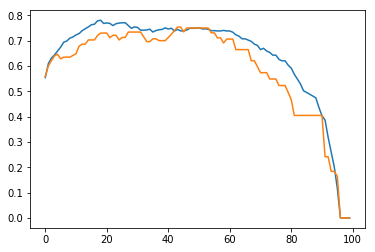

Beginning fold 2
train result: (0.36, 0.7692964094695004)
val result: (0.08, 0.6747587045375654)


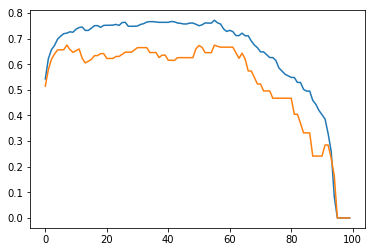

Beginning fold 3
train result: (0.4, 0.7973351673930278)
val result: (0.45, 0.7882691870765812)


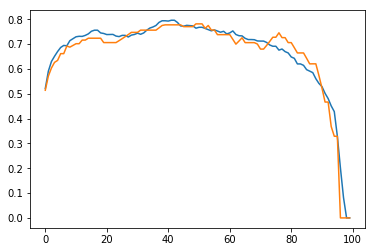

Beginning fold 4
train result: (0.33, 0.7053852134564931)
val result: (0.43, 0.6959706959706959)


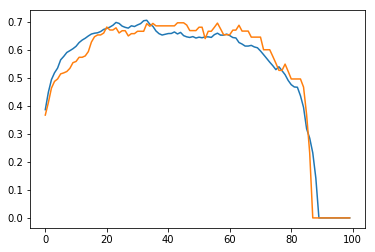

Beginning fold 5
train result: (0.5, 0.7083517248237344)
val result: (0.49, 0.7125591976939062)


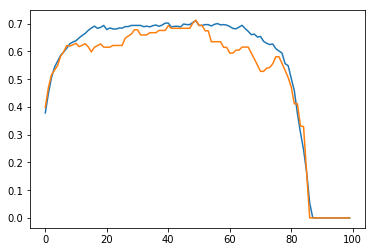

===== n_train = 1 =====
Beginning fold 1
train result: (0.2, 0.6890824565691749)
val result: (0.59, 0.7471598132422994)


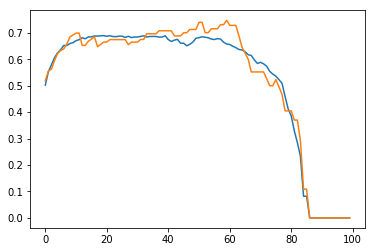

Beginning fold 2
train result: (0.48, 0.7973351673930278)
val result: (0.13, 0.7051924285154925)


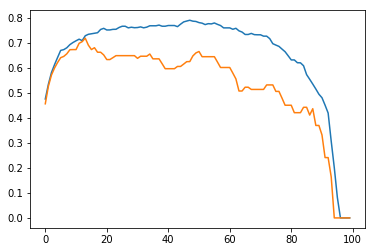

Beginning fold 3
train result: (0.23, 0.7191603746056919)
val result: (0.49, 0.7522642070837813)


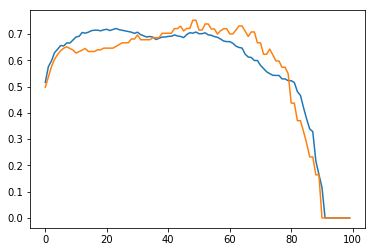

Beginning fold 4
train result: (0.37, 0.7606835515028371)
val result: (0.49, 0.7123848273695446)


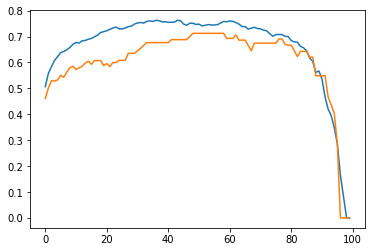

Beginning fold 5
train result: (0.58, 0.8627228358876181)
val result: (0.4, 0.6928411769917774)


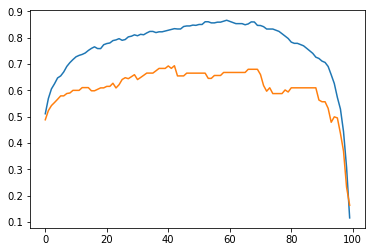

===== n_train = 2 =====
Beginning fold 1
train result: (0.41000000000000003, 0.7456748645923137)
val result: (0.5, 0.7338216065631048)


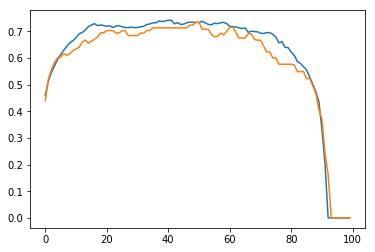

Beginning fold 2
train result: (0.84, 0.7928475835312117)
val result: (0.55, 0.7315179753524961)


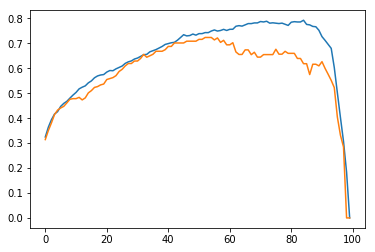

Beginning fold 3
train result: (0.36, 0.7448285993081256)
val result: (0.58, 0.7338216065631048)


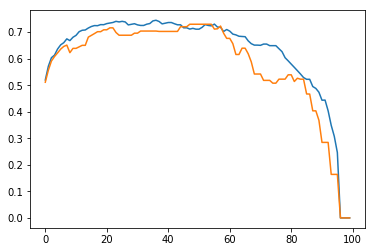

Beginning fold 4
train result: (0.58, 0.8253330491222168)
val result: (0.51, 0.7263736263736263)


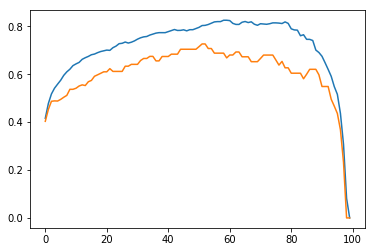

Beginning fold 5
train result: (0.62, 0.7478675771037719)
val result: (0.44, 0.6928411769917774)


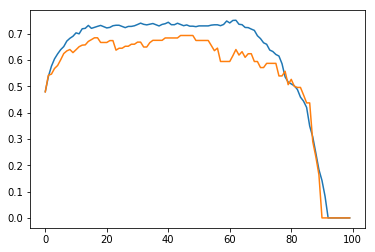

===== n_train = 3 =====
Beginning fold 1
train result: (0.61, 0.7054442602039238)
val result: (0.52, 0.7504603403893452)


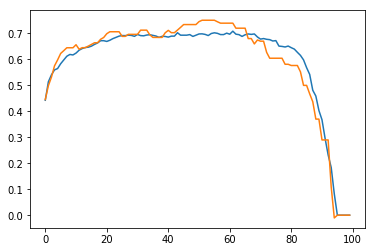

Beginning fold 2
train result: (0.56, 0.8153641243858516)
val result: (0.25, 0.7027005908052064)


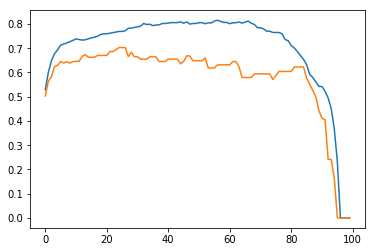

Beginning fold 3
train result: (0.58, 0.7982142852585739)
val result: (0.36, 0.7882691870765812)


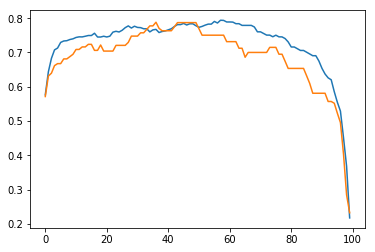

Beginning fold 4
train result: (0.21, 0.7207852377232178)
val result: (0.48, 0.6927828198136694)


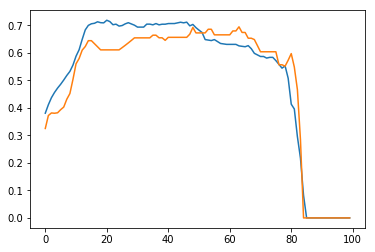

Beginning fold 5
train result: (0.56, 0.7940496335636857)
val result: (0.49, 0.6937116424830102)


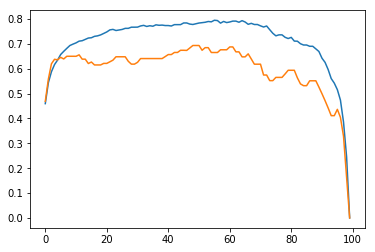

===== n_train = 4 =====
Beginning fold 1
train result: (0.46, 0.7907887977221675)
val result: (0.49, 0.7874211660104642)


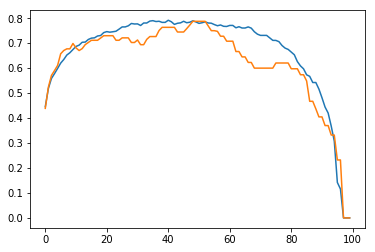

Beginning fold 2
train result: (0.34, 0.8053140980169756)
val result: (0.42, 0.7381607601925768)


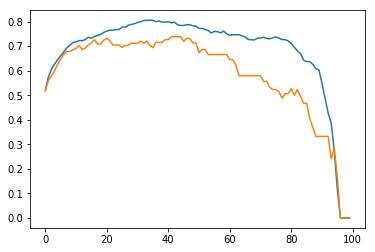

Beginning fold 3
train result: (0.26, 0.692152155635021)
val result: (0.5, 0.78152284306689)


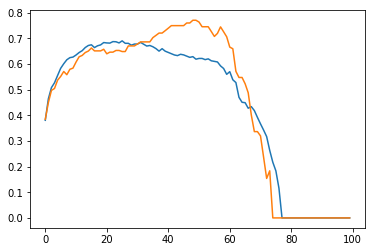

Beginning fold 4
train result: (0.59, 0.7572999581314687)
val result: (0.56, 0.6799373500603623)


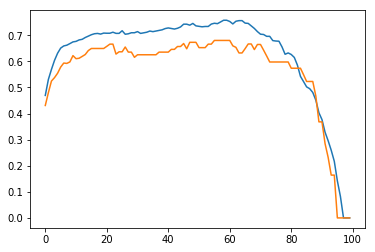

Beginning fold 5
train result: (0.26, 0.8565864866394617)
val result: (0.44, 0.7337913368882756)


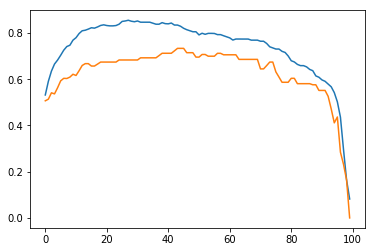

===== n_train = 5 =====
Beginning fold 1
train result: (0.46, 0.7558101090412117)
val result: (0.39, 0.7688521546555444)


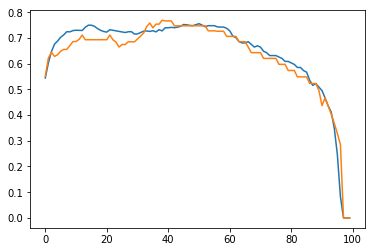

Beginning fold 2
train result: (0.68, 0.7844365368977465)
val result: (0.24, 0.67717058669775)


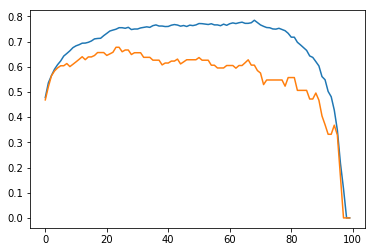

Beginning fold 3
train result: (0.55, 0.7357031261672706)
val result: (0.53, 0.777615829353005)


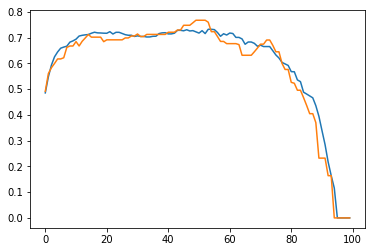

Beginning fold 4
train result: (0.56, 0.7916326426037034)
val result: (0.65, 0.7077537030177518)


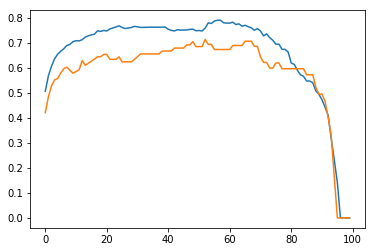

Beginning fold 5
train result: (0.43, 0.8174067934877682)
val result: (0.5, 0.6879199632200284)


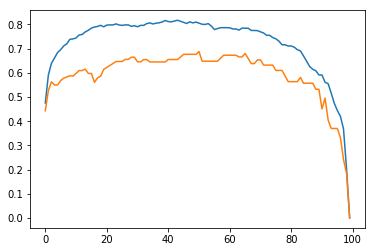

===== n_train = 6 =====
Beginning fold 1
train result: (0.52, 0.7699521899106683)
val result: (0.43, 0.8089465160004735)


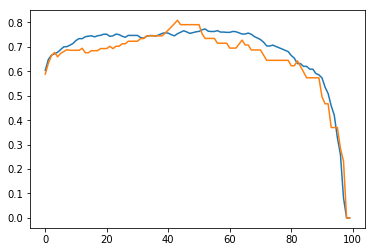

Beginning fold 2
train result: (0.58, 0.6989134205146291)
val result: (0.5, 0.6561965694338815)


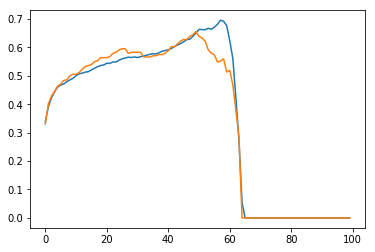

Beginning fold 3
train result: (0.49, 0.7463282321542878)
val result: (0.5, 0.7930698491163516)


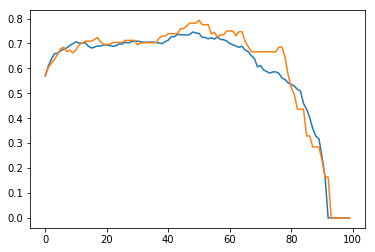

Beginning fold 4
train result: (0.49, 0.8108811592675244)
val result: (0.58, 0.7149248268458614)


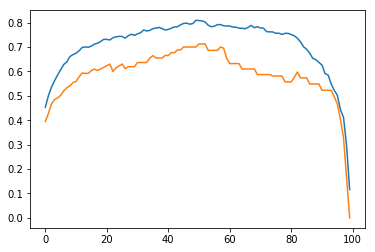

Beginning fold 5
train result: (0.24, 0.7692679635038837)
val result: (0.45, 0.7263433813892529)


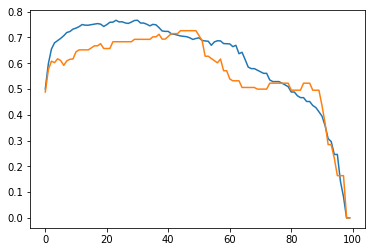

===== n_train = 7 =====
Beginning fold 1
train result: (0.51, 0.7776286235918364)
val result: (0.48, 0.7504603403893452)


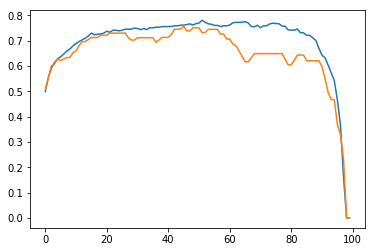

Beginning fold 2
train result: (0.44, 0.8469829006032992)
val result: (0.09, 0.7091005265728487)


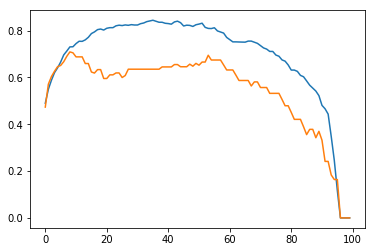

Beginning fold 3
train result: (0.15, 0.6720501847010492)
val result: (0.5, 0.7493698276740993)


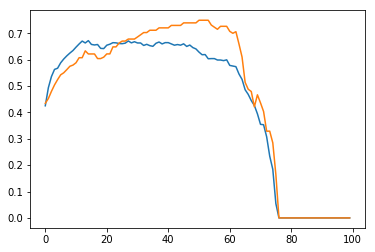

Beginning fold 4
train result: (0.36, 0.7422353336378852)
val result: (0.56, 0.7001233136901053)


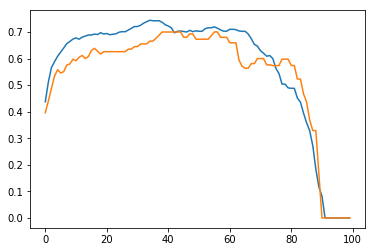

Beginning fold 5
train result: (0.39, 0.7651608942854353)
val result: (0.47000000000000003, 0.7310965795506426)


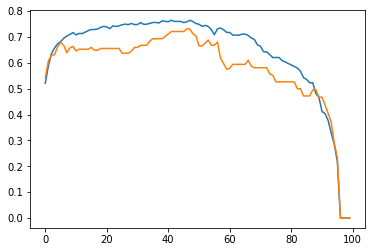

===== n_train = 8 =====
Beginning fold 1
train result: (0.31, 0.6995910218742952)
val result: (0.5, 0.7381607601925768)


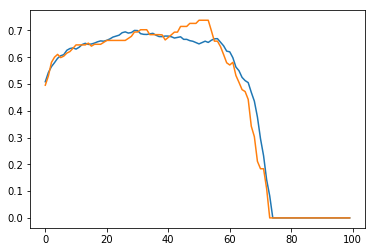

Beginning fold 2
train result: (0.53, 0.8512464333400914)
val result: (0.12, 0.7156230534587152)


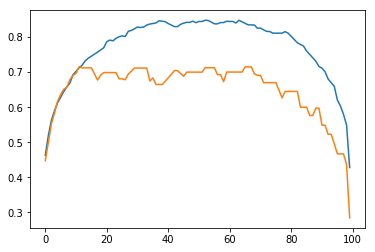

Beginning fold 3
train result: (0.53, 0.7394809835417702)
val result: (0.51, 0.8175824175824176)


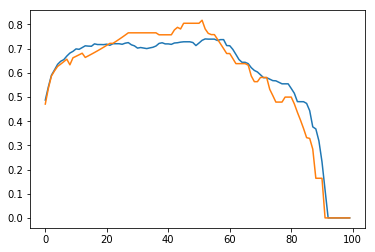

Beginning fold 4
train result: (0.5, 0.7570086292311916)
val result: (0.47000000000000003, 0.693746935117564)


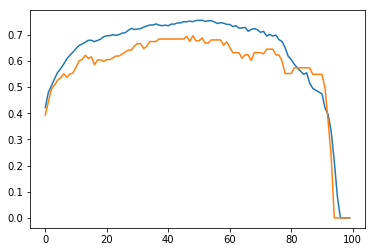

Beginning fold 5
train result: (0.55, 0.7478675771037719)
val result: (0.48, 0.6928411769917774)


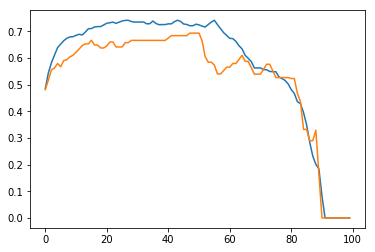

===== n_train = 9 =====
Beginning fold 1
train result: (0.5, 0.6952622308375941)
val result: (0.5, 0.7817138317352136)


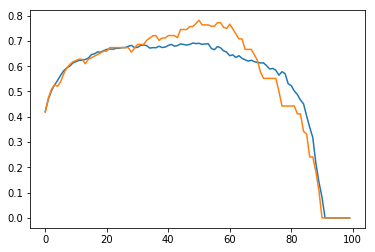

Beginning fold 2
train result: (0.63, 0.7721054246782794)
val result: (0.08, 0.6904062427922711)


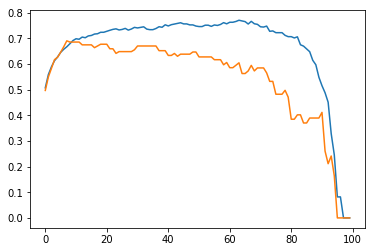

Beginning fold 3
train result: (0.29, 0.774892789674487)
val result: (0.5, 0.8089465160004735)


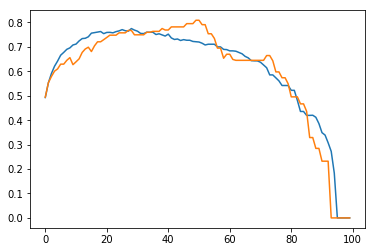

Beginning fold 4
train result: (0.42, 0.6909302355016674)
val result: (0.5, 0.6836849963629029)


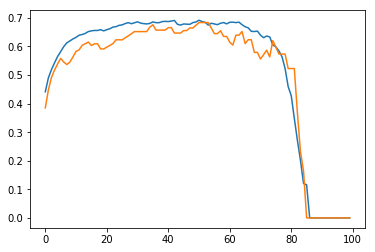

Beginning fold 5
train result: (0.56, 0.7413897446848411)
val result: (0.18, 0.6843316811037657)


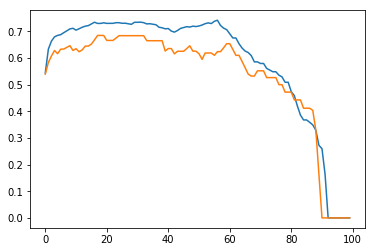

In [58]:
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, fold_index))

for n_train in range(N_TRAIN):
    print(f"===== n_train = {n_train} =====")
    for idx, (train_idx, val_idx) in enumerate(splits):
        print("Beginning fold {}".format(idx+1))   
        train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]
        preds_train = np.load(save_dir + f"preds_train_{n_train}_{idx}.npy")
        preds_val = np.load(save_dir + f"preds_val_{n_train}_{idx}.npy")

        print("train result:", threshold_search(train_y, preds_train))
        print("val result:", threshold_search(val_y, preds_val))
        plot_score(train_y, preds_train)
        plot_score(val_y, preds_val)
        plt.show()

#### (n_train)単位で結果を出力

===== n_train = 0 =====


/home/hakubishin3/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


fold0 result: (0.44, 0.753645477752651)
fold1 result: (0.08, 0.6747587045375654)
fold2 result: (0.45, 0.7882691870765812)
fold3 result: (0.43, 0.6959706959706959)
fold4 result: (0.49, 0.7125591976939062)
val result: (0.5, 0.717806566501789)
===== n_train = 1 =====
fold0 result: (0.59, 0.7471598132422994)
fold1 result: (0.13, 0.7051924285154925)
fold2 result: (0.49, 0.7522642070837813)
fold3 result: (0.49, 0.7123848273695446)
fold4 result: (0.4, 0.6928411769917774)
val result: (0.5, 0.7052330285921334)
===== n_train = 2 =====
fold0 result: (0.5, 0.7338216065631048)
fold1 result: (0.55, 0.7315179753524961)
fold2 result: (0.58, 0.7338216065631048)
fold3 result: (0.51, 0.7263736263736263)
fold4 result: (0.44, 0.6928411769917774)
val result: (0.51, 0.7115892140593755)
===== n_train = 3 =====
fold0 result: (0.52, 0.7504603403893452)
fold1 result: (0.25, 0.7027005908052064)
fold2 result: (0.36, 0.7882691870765812)
fold3 result: (0.48, 0.6927828198136694)
fold4 result: (0.49, 0.693711642483010

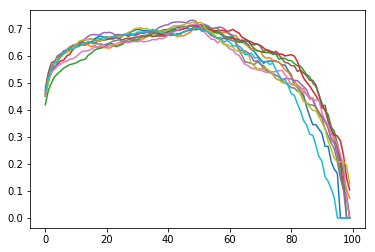

In [59]:
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, fold_index))

for n_train in range(N_TRAIN):
    print(f"===== n_train = {n_train} =====")
    preds_val_all = []
    y_val = []
    
    for idx, (train_idx, val_idx) in enumerate(splits):
        train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]
        preds_train = np.load(save_dir + f"preds_train_{n_train}_{idx}.npy")
        preds_val = np.load(save_dir + f"preds_val_{n_train}_{idx}.npy")
        preds_val_all.append(preds_val)
        y_val.append(val_y)
        print(f"fold{idx} result: {threshold_search(val_y, preds_val)}")

    y_val = np.concatenate(y_val)
    preds_val_all = np.concatenate(preds_val_all)

    print("val result:", threshold_search(y_val, preds_val_all))
    plot_score(y_val, preds_val_all)

### adversarial validation

In [34]:
ad_result = pd.read_csv(save_dir + "adversarial_validation_result.csv")
ad_train = ad_result.query("test_flg == 0").sort_values("idx")
ad_val_idx = ad_train.query("preds > 0.75").idx.values
len(ad_val_idx)

318

In [35]:
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, fold_index))

for n_train in range(N_TRAIN):
    print(f"===== n_train = {n_train} =====")
    preds_val_all = []
    y_val = []
    val_idx_list = []
    
    for idx, (train_idx, val_idx) in enumerate(splits):
        train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]
        preds_train = np.load(save_dir + f"preds_train_{n_train}_{idx}.npy")
        preds_val = np.load(save_dir + f"preds_val_{n_train}_{idx}.npy")
        preds_val_all.append(preds_val)
        y_val.append(val_y)
        val_idx_list.append(val_idx)
        print(f"fold{idx} result: {threshold_search(val_y, preds_val)}")

    y_val = np.concatenate(y_val)
    preds_val_all = np.concatenate(preds_val_all)
    val_idx_list = np.concatenate(val_idx_list)
    
    result_df = []
    for idx, target, preds in zip(val_idx_list, y_val, preds_val_all):
        result_df.append((idx, target, preds))
    result_df = pd.DataFrame(result_df, columns=["idx", "target", "preds"])
    result_df = result_df.sort_values("idx").reset_index(drop=True)
    extract = result_df.query("idx in @ad_val_idx")

    print("val result:", threshold_search(y_val, preds_val_all))
    print("adverl result:", threshold_search(extract.target.values, extract.preds.values))

===== n_train = 0 =====


/home/hakubishin3/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


fold0 result: (0.5700000000000001, 0.7601594864460611)
fold1 result: (0.6, 0.8223644119439366)
fold2 result: (0.46, 0.7828829514354293)
fold3 result: (0.36, 0.7137703636342039)
fold4 result: (0.34, 0.6973963048211226)
val result: (0.5700000000000001, 0.7357577704861323)
adverl result: (0.46, 0.5924082806203598)
===== n_train = 1 =====
fold0 result: (0.52, 0.7601594864460611)
fold1 result: (0.58, 0.7631525492585821)
fold2 result: (0.45, 0.732971967527029)
fold3 result: (0.5700000000000001, 0.7043363928829716)
fold4 result: (0.53, 0.6868371968164555)
val result: (0.52, 0.7183677021026861)
adverl result: (0.5, 0.6272209263704686)
===== n_train = 2 =====
fold0 result: (0.49, 0.7523772784651094)
fold1 result: (0.47000000000000003, 0.8051223219649741)
fold2 result: (0.49, 0.7941787301830776)
fold3 result: (0.54, 0.6754758691515832)
fold4 result: (0.5, 0.7190555176425457)
val result: (0.5, 0.7422619808008578)
adverl result: (0.5, 0.6072370954617966)
===== n_train = 3 =====
fold0 result: (0.51

### predict v1

- n_train = 2の予測を出力
- LB = 0.640, adverl_resultと似ている？

In [91]:
n_train = 0

In [92]:
preds_test = []
for idx in range(N_SPLITS):
    pred = np.load(save_dir + f"preds_test_{n_train}_{idx}.npy")
    pred_3 = []

    for pred_scalar in pred:
        for i in range(3):
            pred_3.append(pred_scalar)
    preds_test.append(pred_3)

In [93]:
best_threshold = 0.49
preds_test = (np.squeeze(np.mean(preds_test, axis=0)) > best_threshold).astype(np.int)
preds_test.shape

(20337,)

In [94]:
submission = pd.read_csv('../data/input/sample_submission.csv')
submission['target'] = preds_test
submission.to_csv(save_dir + 'submission_v1.csv', index=False)
submission.sum()

signal_id    383962560
target             777
dtype: int64

### predict v2

- 全ての(idx, fold)を足し合わせる

In [60]:
from sklearn.calibration import _SigmoidCalibration
from scipy.stats import rankdata

np.warnings.filterwarnings('ignore')
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, fold_index))
scores_all_fold_list = []
preds_val_all = []
y_val = []
val_idx_list = []

for idx, (train_idx, val_idx) in enumerate(splits):
    train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]

    scores_list = []
    preds_val_idx = np.zeros(len(val_y))
    for n_train in range(N_TRAIN):        
        preds_val = np.load(save_dir + f"preds_val_{n_train}_{idx}.npy")
        preds_test = np.load(save_dir + f"preds_test_{n_train}_{idx}.npy")
        preds_val_idx += preds_val / N_TRAIN

        score_list = []
        for thr in np.linspace(0.0, 1.0, 501):
            score = matthews_corrcoef(val_y, (preds_val > thr).astype(np.uint8))
            score_list.append(score)
        scores = np.asarray(score_list)
        scores_list.append(scores)
        
    scores_all_fold_list.append(scores_list)
    preds_val_all.append(preds_val_idx)
    y_val.append(val_y)
    val_idx_list.append(val_idx)
    print(threshold_search(val_y, preds_val_idx))
    
y_val = np.concatenate(y_val)
preds_val_all = np.concatenate(preds_val_all)
print("val result:", threshold_search(y_val, preds_val_all))

(0.48, 0.7950210272370206)
(0.23, 0.72914127121876)
(0.51, 0.8175824175824176)
(0.54, 0.725472401419431)
(0.54, 0.7073103323651386)
val result: (0.49, 0.7286858495006188)


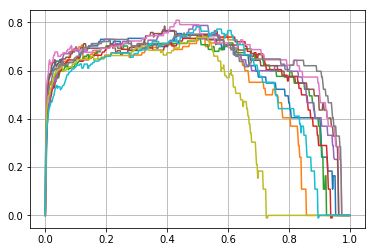

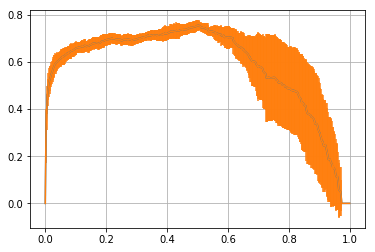

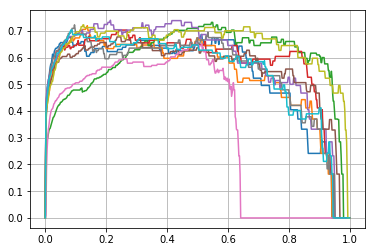

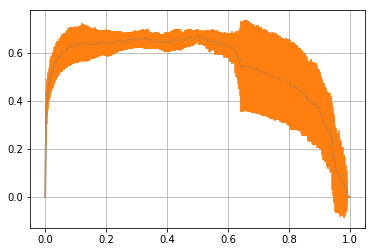

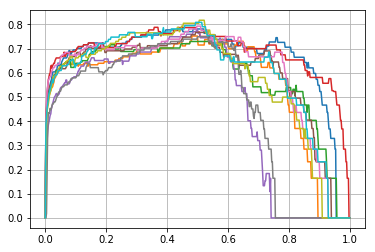

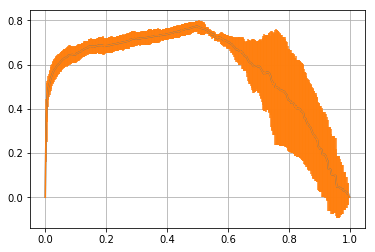

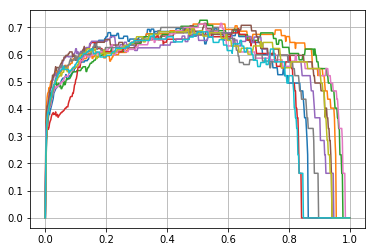

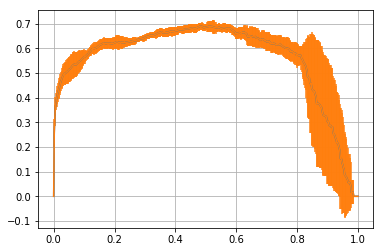

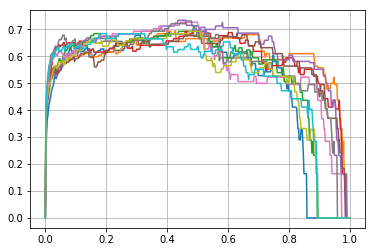

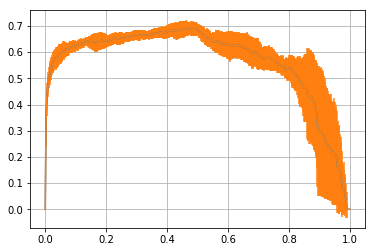

In [61]:
for scores_list in scores_all_fold_list:
    x_line = np.linspace(0.0, 1.0, 501)
    for n_train in range(N_TRAIN):
        plt.plot(x_line, scores_list[n_train])
    plt.grid()
    plt.show()

    mean = np.asarray(scores_list).mean(axis=0)
    std = np.asarray(scores_list).std(axis=0)
    plt.plot(x_line, mean)
    plt.errorbar(x_line, mean, yerr=std)
    plt.grid()
    plt.show()

### predict v3

- 全ての(idx, fold)をsigmoidにスケール変換
- 足し合わせて閾値を決める

In [62]:
from sklearn.calibration import _SigmoidCalibration
from scipy.stats import rankdata

np.warnings.filterwarnings('ignore')
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, fold_index))
scores_all_fold_list = []
preds_val_all = []
preds_test_all = []
y_val = []
val_idx_list = []

for idx, (train_idx, val_idx) in enumerate(splits):
    train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]
    scores_list = []
    preds_val_idx = np.zeros(len(val_y))
    preds_test_idx = np.zeros(len(X_test_input))
    
    for n_train in range(N_TRAIN):        
        preds_val = np.load(save_dir + f"preds_val_{n_train}_{idx}.npy")
        preds_test = np.load(save_dir + f"preds_test_{n_train}_{idx}.npy")
        calb = _SigmoidCalibration()
        calb.fit(preds_val, val_y)
        preds_val = calb.predict(preds_val)
        preds_test = calb.predict(preds_test)
        preds_val_idx += preds_val / N_TRAIN
        preds_test_idx += preds_test / N_TRAIN

        score_list = []
        for thr in np.linspace(0.0, 1.0, 501):
            score = matthews_corrcoef(val_y, (preds_val > thr).astype(np.uint8))
            score_list.append(score)
        scores = np.asarray(score_list)
        scores_list.append(scores)
        
    scores_all_fold_list.append(scores_list)
    preds_val_all.append(preds_val_idx)
    preds_test_all.append(preds_test_idx)
    y_val.append(val_y)
    val_idx_list.append(val_idx)
    print(threshold_search(val_y, preds_val_idx))
    
y_val = np.concatenate(y_val)
preds_val_all = np.concatenate(preds_val_all)
print("val result:", threshold_search(y_val, preds_val_all))

(0.42, 0.8089465160004735)
(0.09, 0.72914127121876)
(0.39, 0.8050788396834601)
(0.41000000000000003, 0.725472401419431)
(0.41000000000000003, 0.7073103323651386)
val result: (0.42, 0.7430932886195595)


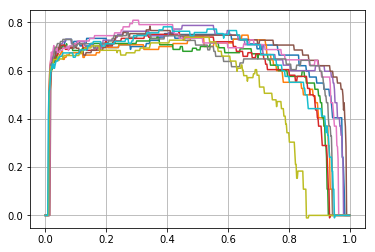

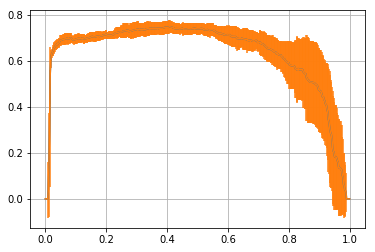

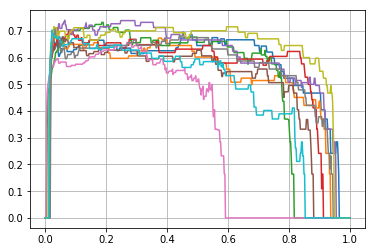

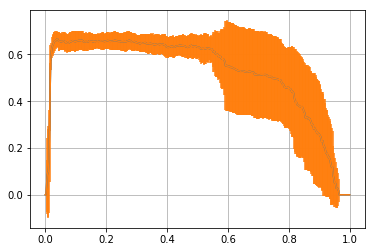

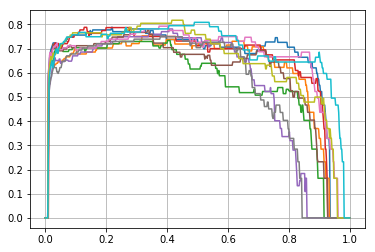

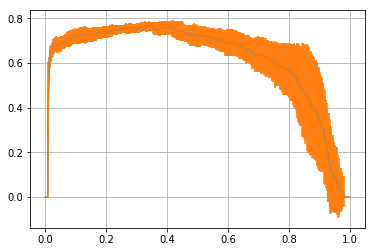

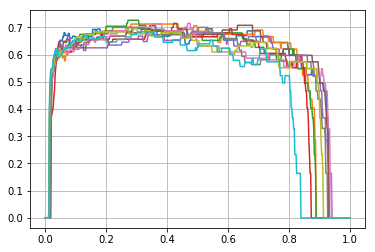

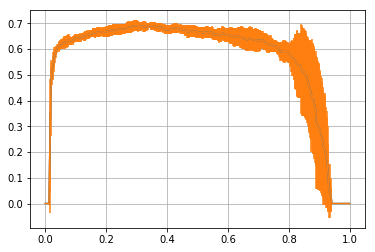

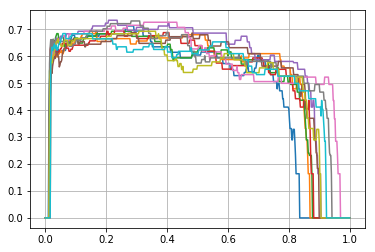

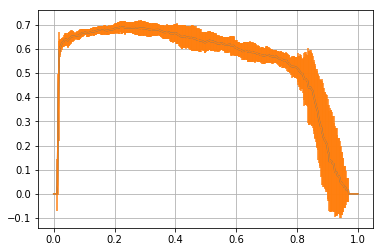

In [63]:
for scores_list in scores_all_fold_list:
    x_line = np.linspace(0.0, 1.0, 501)
    for n_train in range(N_TRAIN):
        plt.plot(x_line, scores_list[n_train])
    plt.grid()
    plt.show()

    mean = np.asarray(scores_list).mean(axis=0)
    std = np.asarray(scores_list).std(axis=0)
    plt.plot(x_line, mean)
    plt.errorbar(x_line, mean, yerr=std)
    plt.grid()
    plt.show()

In [64]:
thr = 0.42
preds_test_sub = np.zeros(len(X_test_input))
for idx, (train_idx, val_idx) in enumerate(splits):
    preds_test_idx = preds_test_all[idx]
    preds_test_sub += preds_test_idx / len(splits)
    
preds_test_sub = (preds_test_sub > thr).astype(int)
preds_test_sub.sum()

242

In [65]:
pred_3 = []
for pred_scaler in preds_test_sub:
    for i in range(3):
        pred_3.append(pred_scaler)
sub = np.squeeze(pred_3)
sub.sum()

726

In [66]:
submission = pd.read_csv('../data/input/sample_submission.csv')
submission['target'] = sub
submission['target'] = submission['target'].astype(int)
submission.to_csv(save_dir + 'submission_v3.csv', index=False)
submission.sum()

signal_id    383962560
target             726
dtype: int64

### predict v4

- 全ての(idx, fold)をrankdataでスケール変換
- 足し合わせて閾値を決める

In [25]:
from sklearn.calibration import _SigmoidCalibration
from scipy.stats import rankdata

np.warnings.filterwarnings('ignore')
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, fold_index))
scores_all_fold_list = []
preds_val_all = []
preds_test_all = []
y_val = []
val_idx_list = []

for idx, (train_idx, val_idx) in enumerate(splits):
    train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]
    scores_list = []
    preds_val_idx = np.zeros(len(val_y))
    preds_test_idx = np.zeros(len(X_test_input))
    
    for n_train in range(N_TRAIN):        
        preds_val = np.load(save_dir + f"preds_val_{n_train}_{idx}.npy")
        preds_test = np.load(save_dir + f"preds_test_{n_train}_{idx}.npy")
        preds_con = np.concatenate((preds_val, preds_test))
        preds_con = rankdata(preds_con) / len(preds_con)
        preds_val_rank = preds_con[0:len(preds_val)]
        preds_test_rank = preds_con[len(preds_val):len(preds_val)+len(preds_test)]
        preds_val_idx += preds_val_rank / N_TRAIN

        score_list = []
        for thr in np.linspace(0.0, 1.0, 501):
            score = matthews_corrcoef(val_y, (preds_val > thr).astype(np.uint8))
            score_list.append(score)
        scores = np.asarray(score_list)
        scores_list.append(scores)
        
    scores_all_fold_list.append(scores_list)
    preds_val_all.append(preds_val_idx)
    preds_test_all.append(preds_test_idx)
    y_val.append(val_y)
    val_idx_list.append(val_idx)
    print(threshold_search(val_y, preds_val_idx))
    
y_val = np.concatenate(y_val)
preds_val_all = np.concatenate(preds_val_all)
val_idx_list = np.concatenate(val_idx_list)
result_df = []
for idx, target, preds in zip(val_idx_list, y_val, preds_val_all):
    result_df.append((idx, target, preds))
result_df = pd.DataFrame(result_df, columns=["idx", "target", "preds"])
result_df = result_df.sort_values("idx").reset_index(drop=True)
extract = result_df.query("idx in @ad_val_idx")

print("val result:", threshold_search(y_val, preds_val_all))
print("adverl result:", threshold_search(extract.target.values, extract.preds.values))

(0.9500000000000001, 0.7419595527914675)
(0.96, 0.7339117527952347)
(0.96, 0.7516547735251194)
(0.97, 0.6997985794736116)
(0.93, 0.6709862765338721)
val result: (0.9500000000000001, 0.7099440449269994)
adverl result: (0.9400000000000001, 0.6002884557845183)
